# Importing

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn_som.som import SOM
import salishsea_tools.viz_tools as sa_vi


# Datasets Preparation

In [2]:
def datasets_preparation():
    
    ds = xr.open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220331_20220331_grid_T.nc')

    # Variable selection
    temp = ds.votemper
    saline = ds.vosaline
    sigma = ds.sigma_theta
    cell = ds.e3t
    date = pd.DatetimeIndex(ds['time_counter'].values)

    # Open the mesh mask
    mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
    mask = mesh.tmask.to_numpy()
    
    return (ds, temp, saline, sigma, cell, date, mask)


# Masking

In [3]:
def masking (depth, temp, saline, sigma, cell, mask):

    temp = temp.where(mask[0,depth]==1)
    saline = saline.where(mask[0,depth]==1)
    sigma = sigma.where(mask[0,depth]==1)
    cell = cell.where(mask[0,depth]==1)

    return (temp, saline, sigma, cell)


# SOM

In [4]:
def som (depth, temp, saline, sigma, cell):
    
    # Post processing 
    inputs = np.stack((temp[0,depth].values.flatten(), saline[0,depth].values.flatten(), sigma[0,depth].values.flatten(), cell[0,depth].values.flatten()))
    indx = np.argwhere(~np.isnan(inputs[0]) & ~np.isnan(inputs[1]) & ~np.isnan(inputs[2]) & ~np.isnan(inputs[3])) 
    inputs2 = np.transpose(inputs)  
    inputs2 = inputs2[indx[:,0]]

    # SOM
    temp_som = SOM(m=2, n=3, dim= inputs2[0,:].size)
    temp_som.fit(inputs2)
    predictions = temp_som.predict(inputs2)

    # Post processing
    unique, counts = np.unique(predictions, return_counts=True)
    indx2 = np.full(inputs[0,:].size,np.nan)
    indx2[indx[:,0]] = predictions
    clusters = np.reshape(indx2,(898,398))   

    return (unique, counts, inputs2, predictions, clusters)


# Printing

In [5]:
def printing (inputs, predictions, unique, counts):

    # Preparation of the dataframe
    d = {'temperature': inputs[:,0], 'salinity': inputs[:,1], 'cluster': predictions}
    df = pd.DataFrame(d) 

    # Calculating the metrics
    mean_temp = np.round(df.groupby('cluster')['temperature'].mean(), 2)
    mean_sal = np.round(df.groupby('cluster')['salinity'].mean(), 2)
    min_temp = np.round(df.groupby('cluster')['temperature'].min(), 2)
    max_temp = np.round(df.groupby('cluster')['temperature'].max(), 2)
    min_sal = np.round(df.groupby('cluster')['salinity'].min(), 2)
    max_sal = np.round(df.groupby('cluster')['salinity'].max(), 2)

    # Printing
    for i in unique:
            print('The amount of grid boxes for cluster ' + str(i), 'is ' + str(counts[i]), '\n')

            print ('The minimum temperature for cluster '+ str(i), 'is ' + str(min_temp[i]), 'degrees Celsius')
            print ('The maximum temperature for cluster '+ str(i), 'is ' + str(max_temp[i]), 'degrees Celsius')
            print ('The mean temperature for cluster '+ str(i), 'is ' + str(mean_temp[i]), 'degrees Celsius', '\n')

            print ('The minimum salinity for cluster '+ str(i), 'is ' + str(min_sal[i]), 'g/kg')
            print ('The maximum salinity for cluster '+ str(i), 'is ' + str(max_sal[i]), 'g/kg')
            print ('The mean salinity for cluster '+ str(i), 'is ' + str(mean_sal[i]), 'g/kg', '\n'*2)
        

# Plotting

In [6]:
def plotting (depth, clusters, unique):

    # Preparation of the dataarray 
    map = xr.DataArray(clusters,
                    coords = {'y': temp[0,depth].y, 'x': temp[0,depth].x},
                    dims = ['y','x'],
                    attrs=dict(description="Clusters of the performed self organizing map algorithm",
                                long_name ="Cluster",
                                units="count"),
                    ) 

    fig, ax = plt.subplots(1, 1, figsize=(5, 9))

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9,                    
                    )
    
    cmap = plt.get_cmap('viridis', int(unique.max()+1))
    cmap.set_bad('gray')

    map.plot.pcolormesh(ax=ax, cmap=cmap, levels= np.concatenate((unique,[unique.size])), cbar_kwargs={'ticks': unique}) 
    sa_vi.set_aspect(ax)
    ax.set_title('Depth: ' + str(np.round(ds['deptht'][depth].values,2)) + ' meters')

    if date[0].month < 10:
        month = '0' + str(date[0].month)
    else:
        month = str(date[0].month)

    if date[0].day < 10:
        day = '0' + str(date[0].day)  
    else:
        day = str(date[0].day) 

    fig.suptitle('SOM clustering using temperature, salinity, sigma-t and e3t for ' + str(date[0].year) + '/' + month + '/' + day)
    plt.show()


# Main FOR Loop From Where All Functions are Called

The amount of grid boxes for cluster 0 is 7325 

The minimum temperature for cluster 0 is 7.28 degrees Celsius
The maximum temperature for cluster 0 is 10.58 degrees Celsius
The mean temperature for cluster 0 is 9.17 degrees Celsius 

The minimum salinity for cluster 0 is 21.6 g/kg
The maximum salinity for cluster 0 is 24.83 g/kg
The mean salinity for cluster 0 is 23.49 g/kg 


The amount of grid boxes for cluster 1 is 13707 

The minimum temperature for cluster 1 is 7.38 degrees Celsius
The maximum temperature for cluster 1 is 10.53 degrees Celsius
The mean temperature for cluster 1 is 9.08 degrees Celsius 

The minimum salinity for cluster 1 is 24.57 g/kg
The maximum salinity for cluster 1 is 27.25 g/kg
The mean salinity for cluster 1 is 25.83 g/kg 


The amount of grid boxes for cluster 2 is 15260 

The minimum temperature for cluster 2 is 7.49 degrees Celsius
The maximum temperature for cluster 2 is 10.01 degrees Celsius
The mean temperature for cluster 2 is 8.63 degrees Celsius 



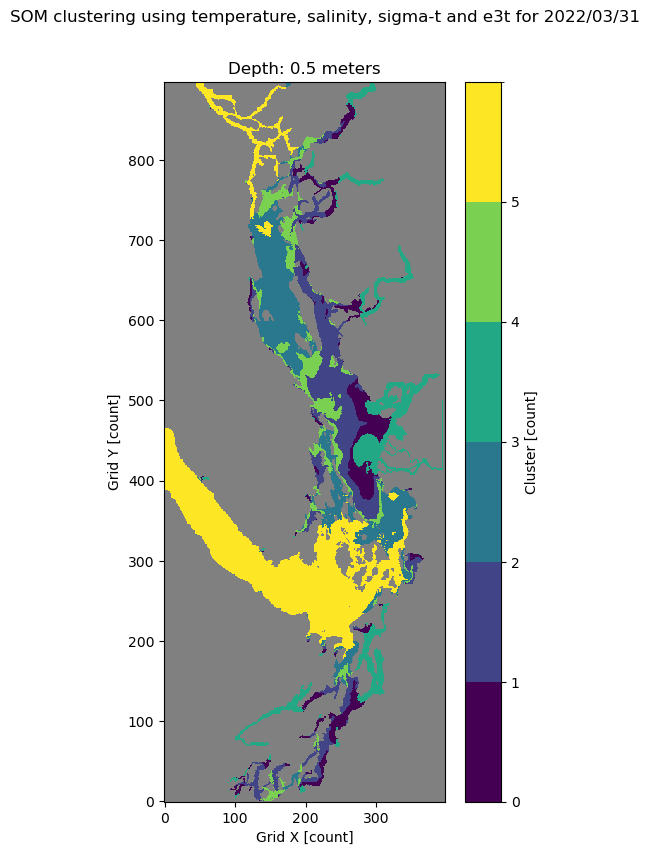

The amount of grid boxes for cluster 0 is 6621 

The minimum temperature for cluster 0 is 7.26 degrees Celsius
The maximum temperature for cluster 0 is 10.54 degrees Celsius
The mean temperature for cluster 0 is 9.17 degrees Celsius 

The minimum salinity for cluster 0 is 22.73 g/kg
The maximum salinity for cluster 0 is 25.24 g/kg
The mean salinity for cluster 0 is 24.19 g/kg 


The amount of grid boxes for cluster 1 is 10491 

The minimum temperature for cluster 1 is 7.42 degrees Celsius
The maximum temperature for cluster 1 is 10.0 degrees Celsius
The mean temperature for cluster 1 is 8.68 degrees Celsius 

The minimum salinity for cluster 1 is 26.7 g/kg
The maximum salinity for cluster 1 is 28.21 g/kg
The mean salinity for cluster 1 is 27.45 g/kg 


The amount of grid boxes for cluster 2 is 28231 

The minimum temperature for cluster 2 is 6.72 degrees Celsius
The maximum temperature for cluster 2 is 9.72 degrees Celsius
The mean temperature for cluster 2 is 8.01 degrees Celsius 

Th

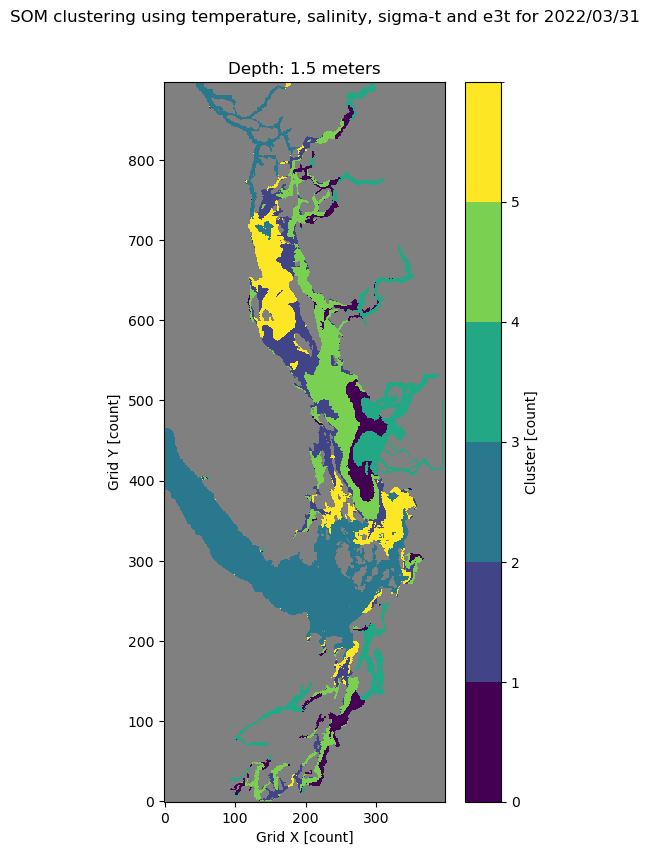

The amount of grid boxes for cluster 0 is 9291 

The minimum temperature for cluster 0 is 6.25 degrees Celsius
The maximum temperature for cluster 0 is 11.12 degrees Celsius
The mean temperature for cluster 0 is 9.04 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 23.86 g/kg
The mean salinity for cluster 0 is 19.15 g/kg 


The amount of grid boxes for cluster 1 is 13782 

The minimum temperature for cluster 1 is 7.48 degrees Celsius
The maximum temperature for cluster 1 is 10.3 degrees Celsius
The mean temperature for cluster 1 is 8.8 degrees Celsius 

The minimum salinity for cluster 1 is 25.46 g/kg
The maximum salinity for cluster 1 is 27.17 g/kg
The mean salinity for cluster 1 is 26.5 g/kg 


The amount of grid boxes for cluster 2 is 9417 

The minimum temperature for cluster 2 is 7.28 degrees Celsius
The maximum temperature for cluster 2 is 9.74 degrees Celsius
The mean temperature for cluster 2 is 8.39 degrees Celsius 

The mi

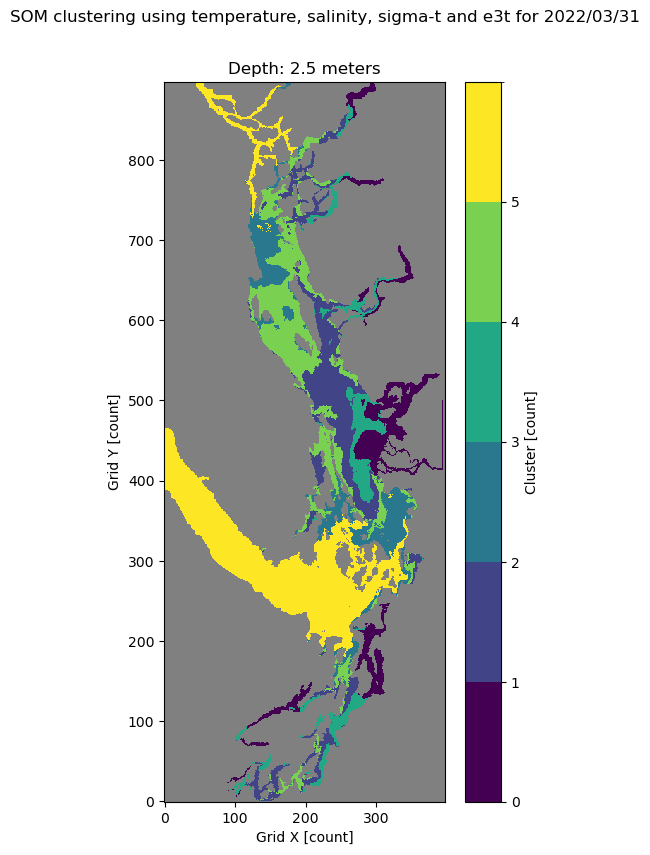

The amount of grid boxes for cluster 0 is 6936 

The minimum temperature for cluster 0 is 7.51 degrees Celsius
The maximum temperature for cluster 0 is 10.52 degrees Celsius
The mean temperature for cluster 0 is 8.98 degrees Celsius 

The minimum salinity for cluster 0 is 23.76 g/kg
The maximum salinity for cluster 0 is 26.28 g/kg
The mean salinity for cluster 0 is 25.22 g/kg 


The amount of grid boxes for cluster 1 is 11978 

The minimum temperature for cluster 1 is 7.43 degrees Celsius
The maximum temperature for cluster 1 is 10.17 degrees Celsius
The mean temperature for cluster 1 is 8.45 degrees Celsius 

The minimum salinity for cluster 1 is 27.21 g/kg
The maximum salinity for cluster 1 is 28.29 g/kg
The mean salinity for cluster 1 is 27.7 g/kg 


The amount of grid boxes for cluster 2 is 14420 

The minimum temperature for cluster 2 is 7.32 degrees Celsius
The maximum temperature for cluster 2 is 9.71 degrees Celsius
The mean temperature for cluster 2 is 8.38 degrees Celsius 

T

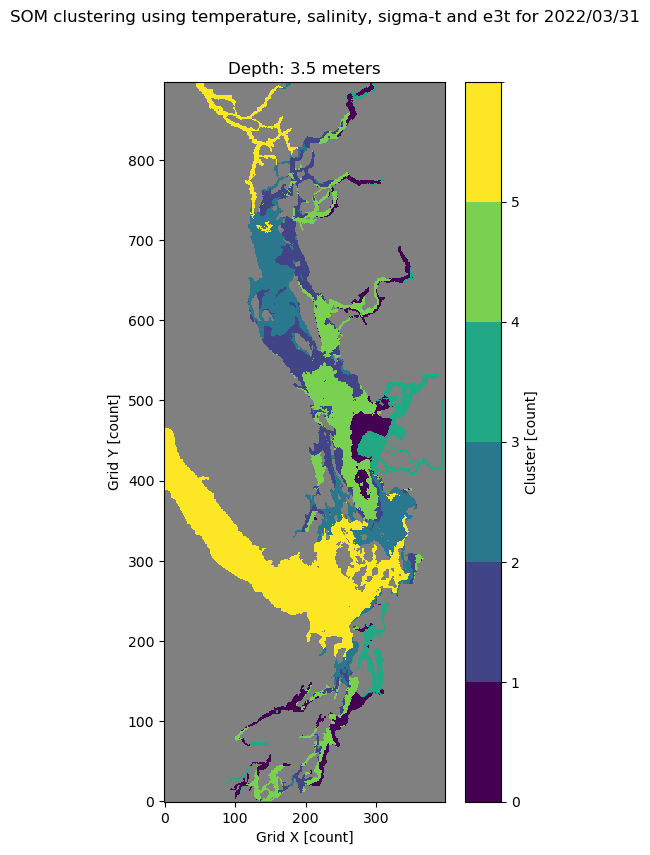

The amount of grid boxes for cluster 0 is 25203 

The minimum temperature for cluster 0 is 6.67 degrees Celsius
The maximum temperature for cluster 0 is 9.36 degrees Celsius
The mean temperature for cluster 0 is 7.94 degrees Celsius 

The minimum salinity for cluster 0 is 29.12 g/kg
The maximum salinity for cluster 0 is 31.36 g/kg
The mean salinity for cluster 0 is 30.46 g/kg 


The amount of grid boxes for cluster 1 is 11327 

The minimum temperature for cluster 1 is 7.32 degrees Celsius
The maximum temperature for cluster 1 is 8.53 degrees Celsius
The mean temperature for cluster 1 is 8.08 degrees Celsius 

The minimum salinity for cluster 1 is 27.05 g/kg
The maximum salinity for cluster 1 is 28.61 g/kg
The mean salinity for cluster 1 is 28.07 g/kg 


The amount of grid boxes for cluster 2 is 5946 

The minimum temperature for cluster 2 is 6.25 degrees Celsius
The maximum temperature for cluster 2 is 10.53 degrees Celsius
The mean temperature for cluster 2 is 8.62 degrees Celsius 

T

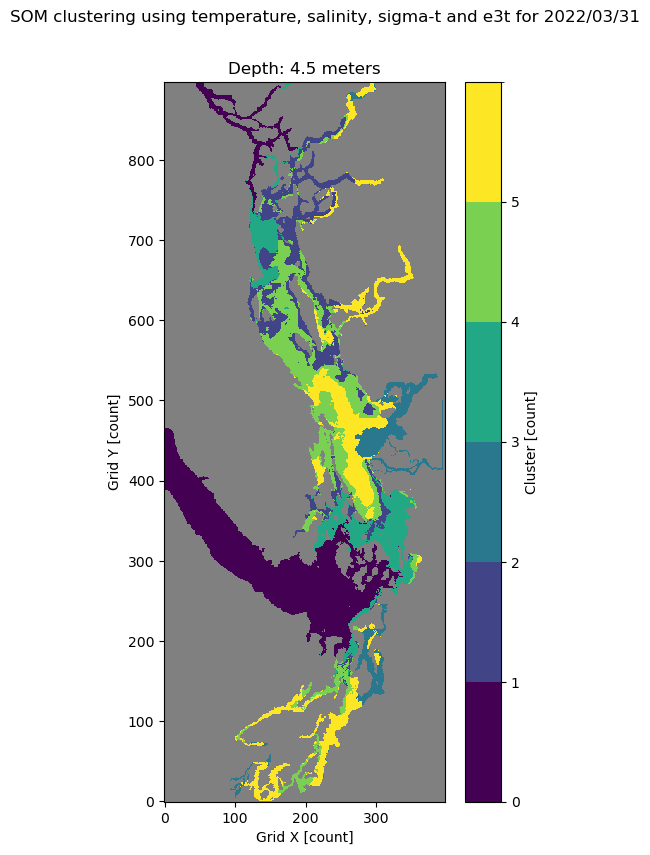

The amount of grid boxes for cluster 0 is 14071 

The minimum temperature for cluster 0 is 6.25 degrees Celsius
The maximum temperature for cluster 0 is 10.37 degrees Celsius
The mean temperature for cluster 0 is 8.58 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 27.72 g/kg
The mean salinity for cluster 0 is 25.29 g/kg 


The amount of grid boxes for cluster 1 is 7206 

The minimum temperature for cluster 1 is 7.85 degrees Celsius
The maximum temperature for cluster 1 is 9.33 degrees Celsius
The mean temperature for cluster 1 is 8.27 degrees Celsius 

The minimum salinity for cluster 1 is 28.55 g/kg
The maximum salinity for cluster 1 is 29.23 g/kg
The mean salinity for cluster 1 is 28.82 g/kg 


The amount of grid boxes for cluster 2 is 21846 

The minimum temperature for cluster 2 is 6.74 degrees Celsius
The maximum temperature for cluster 2 is 9.05 degrees Celsius
The mean temperature for cluster 2 is 7.92 degrees Celsius 

The

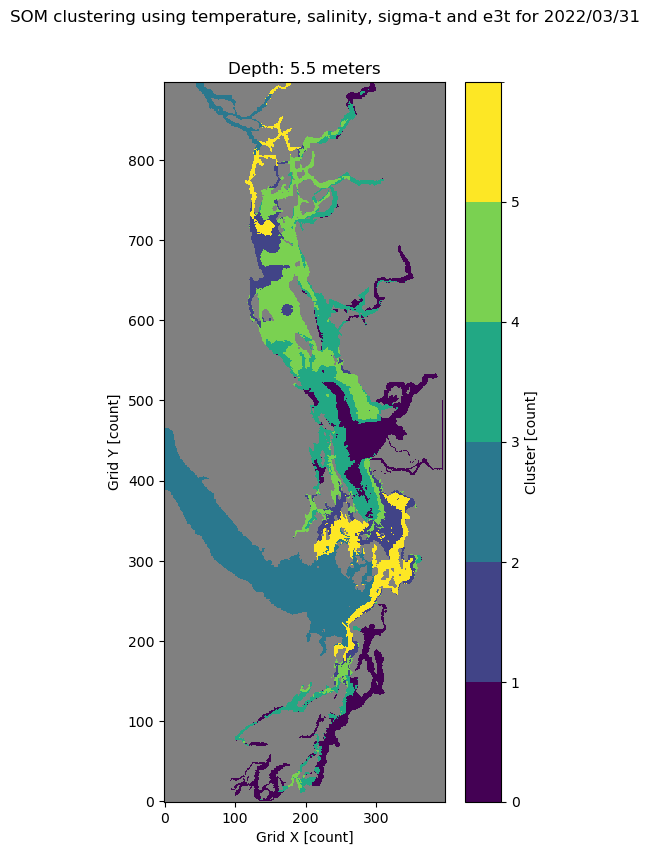

The amount of grid boxes for cluster 0 is 20604 

The minimum temperature for cluster 0 is 7.32 degrees Celsius
The maximum temperature for cluster 0 is 9.02 degrees Celsius
The mean temperature for cluster 0 is 7.91 degrees Celsius 

The minimum salinity for cluster 0 is 29.83 g/kg
The maximum salinity for cluster 0 is 31.42 g/kg
The mean salinity for cluster 0 is 30.66 g/kg 


The amount of grid boxes for cluster 1 is 6881 

The minimum temperature for cluster 1 is 7.74 degrees Celsius
The maximum temperature for cluster 1 is 9.06 degrees Celsius
The mean temperature for cluster 1 is 8.2 degrees Celsius 

The minimum salinity for cluster 1 is 28.8 g/kg
The maximum salinity for cluster 1 is 29.43 g/kg
The mean salinity for cluster 1 is 29.09 g/kg 


The amount of grid boxes for cluster 2 is 11346 

The minimum temperature for cluster 2 is 7.41 degrees Celsius
The maximum temperature for cluster 2 is 10.2 degrees Celsius
The mean temperature for cluster 2 is 8.17 degrees Celsius 

The 

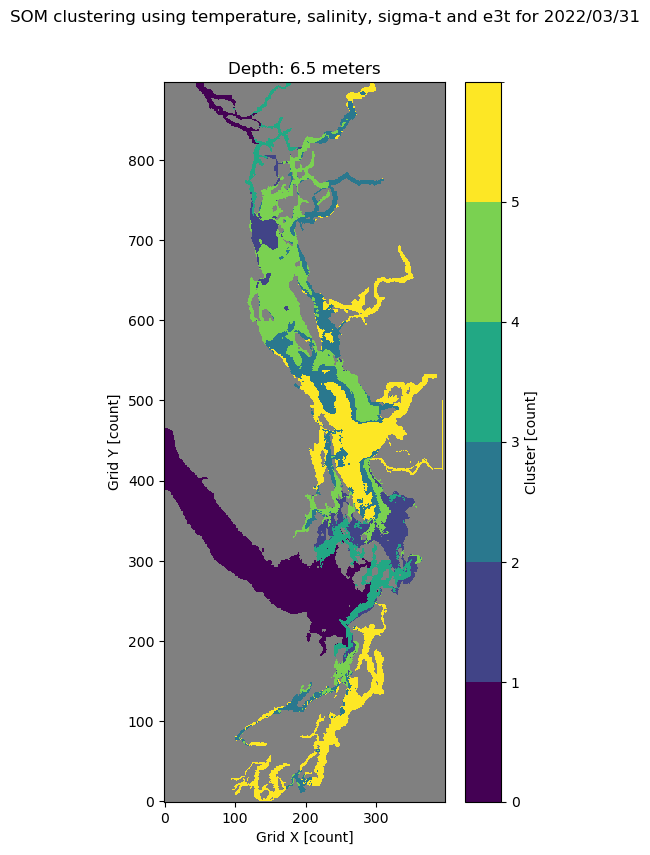

The amount of grid boxes for cluster 0 is 10103 

The minimum temperature for cluster 0 is 6.25 degrees Celsius
The maximum temperature for cluster 0 is 9.7 degrees Celsius
The mean temperature for cluster 0 is 8.36 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 27.7 g/kg
The mean salinity for cluster 0 is 26.13 g/kg 


The amount of grid boxes for cluster 1 is 19572 

The minimum temperature for cluster 1 is 7.41 degrees Celsius
The maximum temperature for cluster 1 is 10.2 degrees Celsius
The mean temperature for cluster 1 is 8.09 degrees Celsius 

The minimum salinity for cluster 1 is 28.05 g/kg
The maximum salinity for cluster 1 is 28.9 g/kg
The mean salinity for cluster 1 is 28.45 g/kg 


The amount of grid boxes for cluster 2 is 6552 

The minimum temperature for cluster 2 is 6.19 degrees Celsius
The maximum temperature for cluster 2 is 9.03 degrees Celsius
The mean temperature for cluster 2 is 8.01 degrees Celsius 

The min

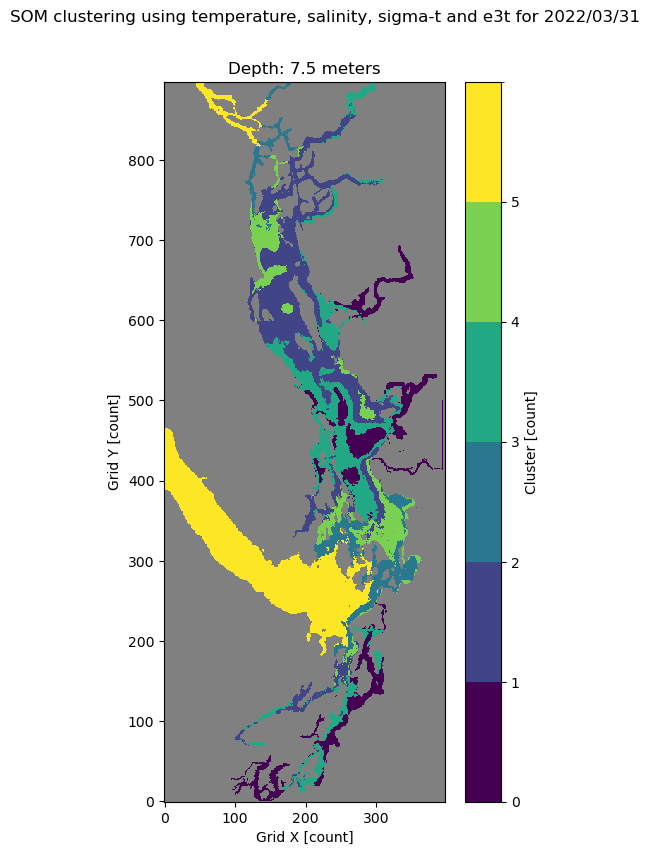

The amount of grid boxes for cluster 0 is 15661 

The minimum temperature for cluster 0 is 7.36 degrees Celsius
The maximum temperature for cluster 0 is 10.27 degrees Celsius
The mean temperature for cluster 0 is 8.31 degrees Celsius 

The minimum salinity for cluster 0 is 27.07 g/kg
The maximum salinity for cluster 0 is 28.39 g/kg
The mean salinity for cluster 0 is 27.83 g/kg 


The amount of grid boxes for cluster 1 is 13036 

The minimum temperature for cluster 1 is 7.67 degrees Celsius
The maximum temperature for cluster 1 is 10.27 degrees Celsius
The mean temperature for cluster 1 is 8.26 degrees Celsius 

The minimum salinity for cluster 1 is 28.39 g/kg
The maximum salinity for cluster 1 is 29.2 g/kg
The mean salinity for cluster 1 is 28.83 g/kg 


The amount of grid boxes for cluster 2 is 7875 

The minimum temperature for cluster 2 is 6.15 degrees Celsius
The maximum temperature for cluster 2 is 8.88 degrees Celsius
The mean temperature for cluster 2 is 8.04 degrees Celsius 

T

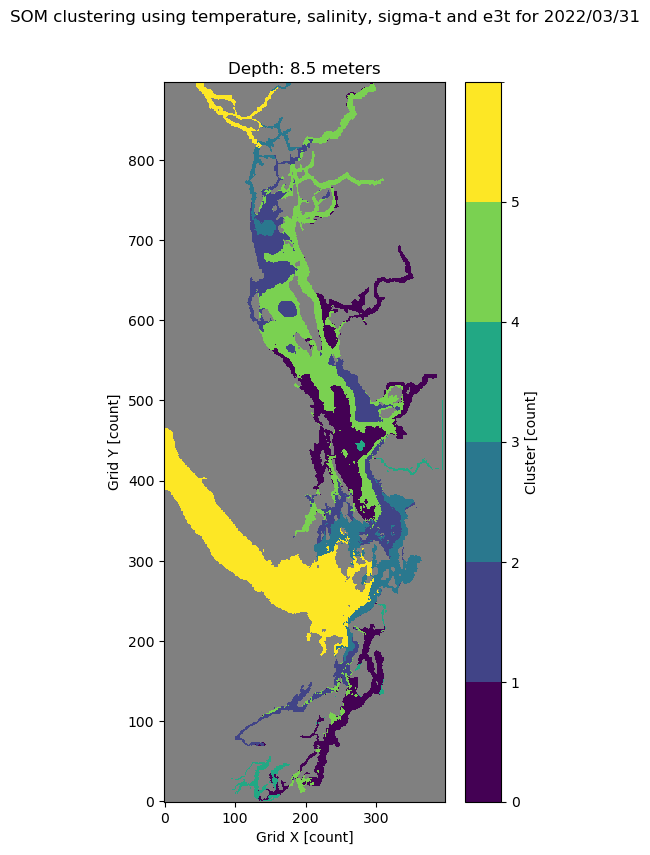

The amount of grid boxes for cluster 0 is 18554 

The minimum temperature for cluster 0 is 6.25 degrees Celsius
The maximum temperature for cluster 0 is 10.27 degrees Celsius
The mean temperature for cluster 0 is 8.4 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 29.09 g/kg
The mean salinity for cluster 0 is 27.53 g/kg 


The amount of grid boxes for cluster 1 is 5816 

The minimum temperature for cluster 1 is 7.57 degrees Celsius
The maximum temperature for cluster 1 is 8.84 degrees Celsius
The mean temperature for cluster 1 is 8.09 degrees Celsius 

The minimum salinity for cluster 1 is 29.13 g/kg
The maximum salinity for cluster 1 is 29.66 g/kg
The mean salinity for cluster 1 is 29.36 g/kg 


The amount of grid boxes for cluster 2 is 17694 

The minimum temperature for cluster 2 is 7.34 degrees Celsius
The maximum temperature for cluster 2 is 8.4 degrees Celsius
The mean temperature for cluster 2 is 7.87 degrees Celsius 

The m

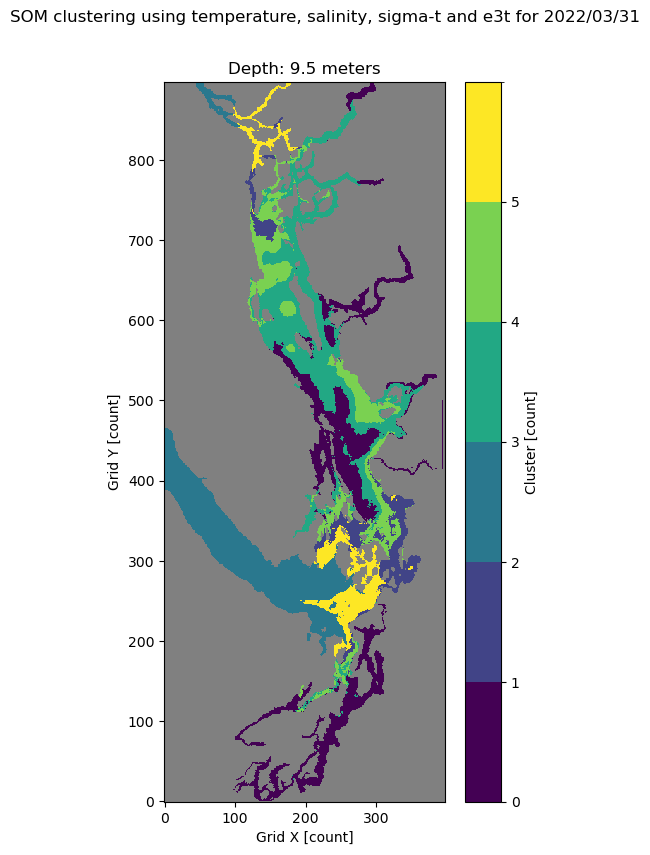

The amount of grid boxes for cluster 0 is 16345 

The minimum temperature for cluster 0 is 7.38 degrees Celsius
The maximum temperature for cluster 0 is 8.34 degrees Celsius
The mean temperature for cluster 0 is 7.9 degrees Celsius 

The minimum salinity for cluster 0 is 27.74 g/kg
The maximum salinity for cluster 0 is 28.66 g/kg
The mean salinity for cluster 0 is 28.45 g/kg 


The amount of grid boxes for cluster 1 is 11912 

The minimum temperature for cluster 1 is 7.57 degrees Celsius
The maximum temperature for cluster 1 is 8.96 degrees Celsius
The mean temperature for cluster 1 is 8.07 degrees Celsius 

The minimum salinity for cluster 1 is 28.64 g/kg
The maximum salinity for cluster 1 is 29.01 g/kg
The mean salinity for cluster 1 is 28.79 g/kg 


The amount of grid boxes for cluster 2 is 6531 

The minimum temperature for cluster 2 is 6.22 degrees Celsius
The maximum temperature for cluster 2 is 8.64 degrees Celsius
The mean temperature for cluster 2 is 7.93 degrees Celsius 

The

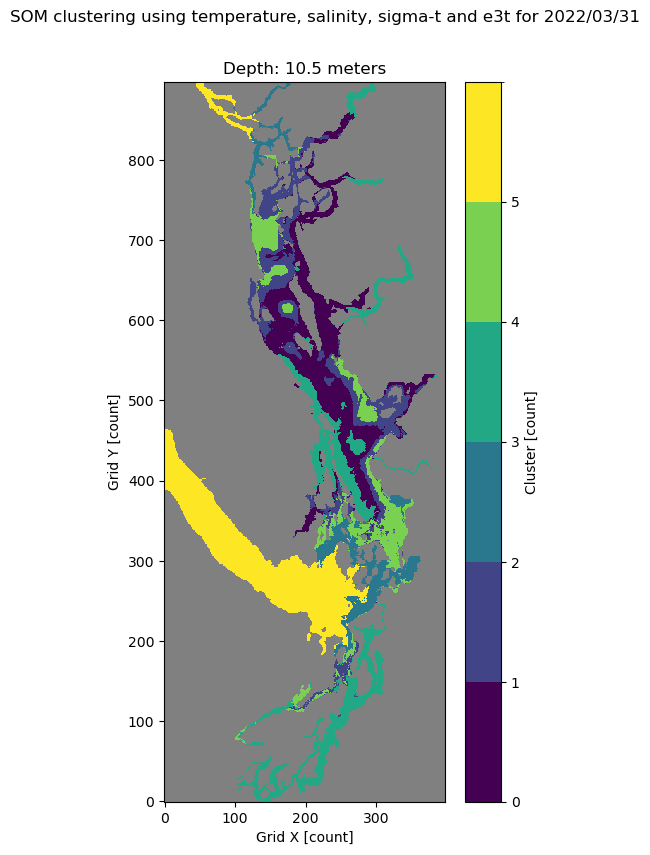

The amount of grid boxes for cluster 0 is 17087 

The minimum temperature for cluster 0 is 7.28 degrees Celsius
The maximum temperature for cluster 0 is 8.33 degrees Celsius
The mean temperature for cluster 0 is 7.85 degrees Celsius 

The minimum salinity for cluster 0 is 30.19 g/kg
The maximum salinity for cluster 0 is 31.61 g/kg
The mean salinity for cluster 0 is 30.84 g/kg 


The amount of grid boxes for cluster 1 is 5654 

The minimum temperature for cluster 1 is 7.54 degrees Celsius
The maximum temperature for cluster 1 is 10.18 degrees Celsius
The mean temperature for cluster 1 is 8.06 degrees Celsius 

The minimum salinity for cluster 1 is 29.17 g/kg
The maximum salinity for cluster 1 is 29.73 g/kg
The mean salinity for cluster 1 is 29.43 g/kg 


The amount of grid boxes for cluster 2 is 16072 

The minimum temperature for cluster 2 is 6.41 degrees Celsius
The maximum temperature for cluster 2 is 10.43 degrees Celsius
The mean temperature for cluster 2 is 8.46 degrees Celsius 



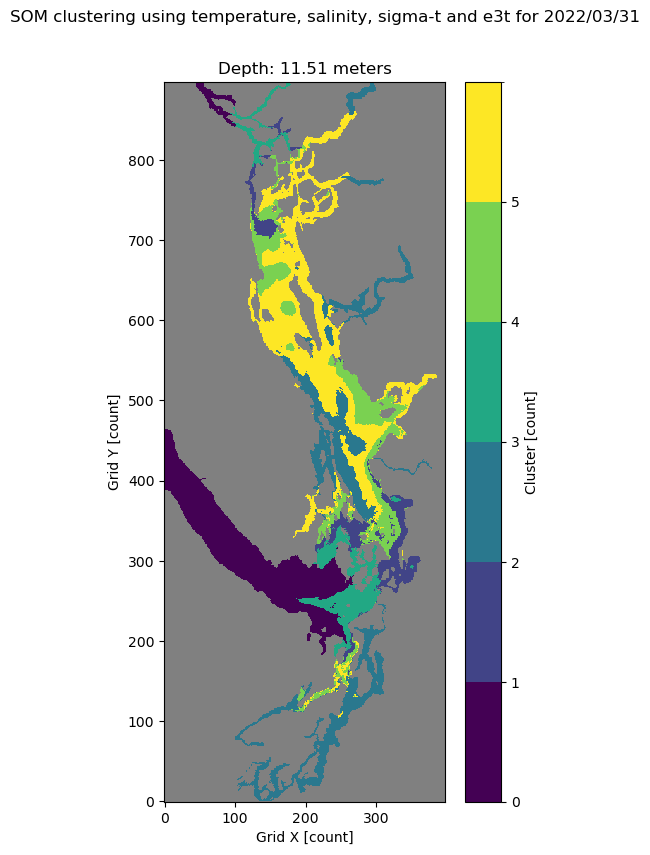

The amount of grid boxes for cluster 0 is 5245 

The minimum temperature for cluster 0 is 6.45 degrees Celsius
The maximum temperature for cluster 0 is 8.65 degrees Celsius
The mean temperature for cluster 0 is 7.89 degrees Celsius 

The minimum salinity for cluster 0 is 29.58 g/kg
The maximum salinity for cluster 0 is 30.14 g/kg
The mean salinity for cluster 0 is 29.89 g/kg 


The amount of grid boxes for cluster 1 is 14786 

The minimum temperature for cluster 1 is 7.7 degrees Celsius
The maximum temperature for cluster 1 is 10.19 degrees Celsius
The mean temperature for cluster 1 is 8.2 degrees Celsius 

The minimum salinity for cluster 1 is 28.84 g/kg
The maximum salinity for cluster 1 is 29.4 g/kg
The mean salinity for cluster 1 is 29.05 g/kg 


The amount of grid boxes for cluster 2 is 12199 

The minimum temperature for cluster 2 is 6.41 degrees Celsius
The maximum temperature for cluster 2 is 10.5 degrees Celsius
The mean temperature for cluster 2 is 8.51 degrees Celsius 

The 

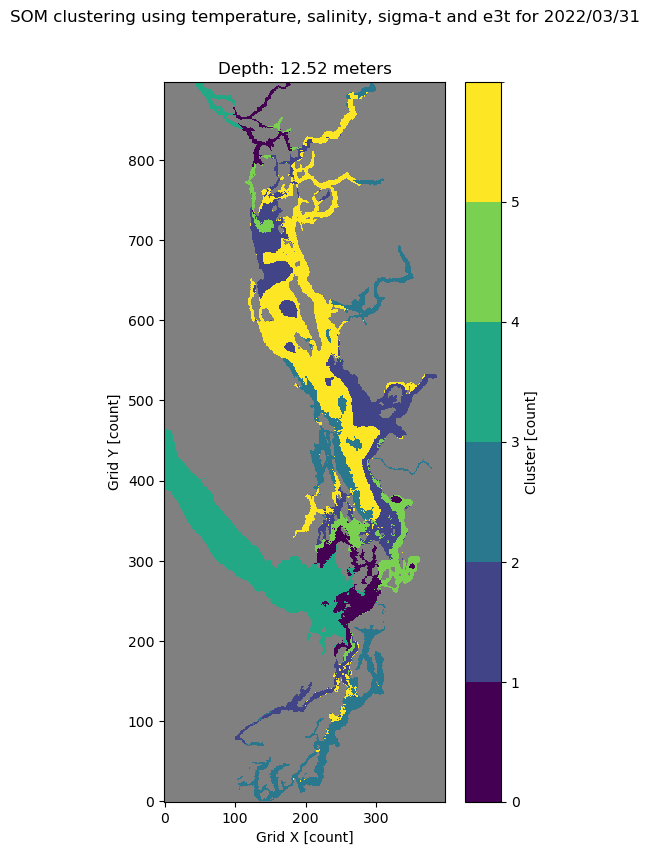

The amount of grid boxes for cluster 0 is 19513 

The minimum temperature for cluster 0 is 7.37 degrees Celsius
The maximum temperature for cluster 0 is 8.97 degrees Celsius
The mean temperature for cluster 0 is 7.95 degrees Celsius 

The minimum salinity for cluster 0 is 28.34 g/kg
The maximum salinity for cluster 0 is 28.87 g/kg
The mean salinity for cluster 0 is 28.66 g/kg 


The amount of grid boxes for cluster 1 is 6236 

The minimum temperature for cluster 1 is 7.54 degrees Celsius
The maximum temperature for cluster 1 is 8.59 degrees Celsius
The mean temperature for cluster 1 is 8.06 degrees Celsius 

The minimum salinity for cluster 1 is 29.12 g/kg
The maximum salinity for cluster 1 is 29.61 g/kg
The mean salinity for cluster 1 is 29.36 g/kg 


The amount of grid boxes for cluster 2 is 18880 

The minimum temperature for cluster 2 is 7.24 degrees Celsius
The maximum temperature for cluster 2 is 8.32 degrees Celsius
The mean temperature for cluster 2 is 7.84 degrees Celsius 

Th

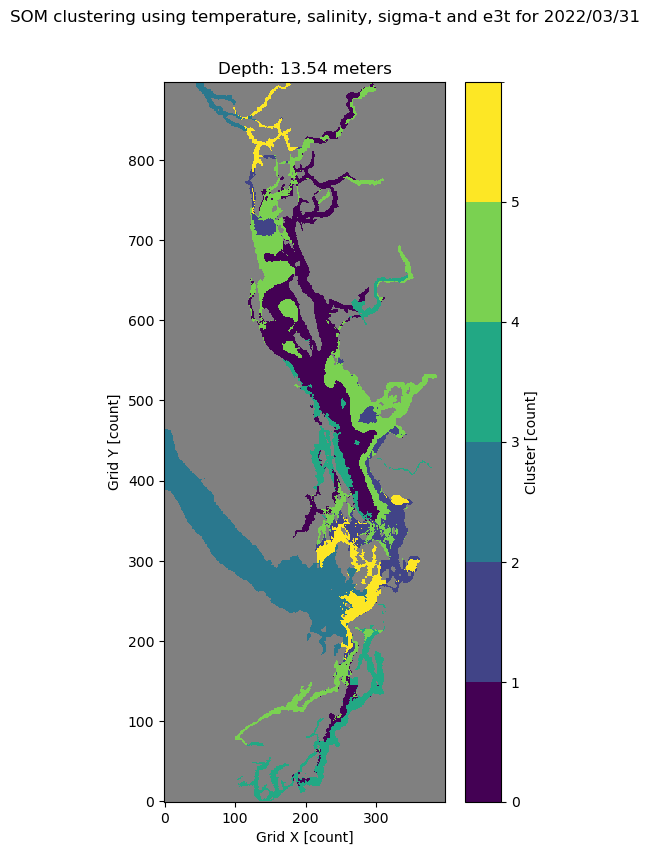

The amount of grid boxes for cluster 0 is 16863 

The minimum temperature for cluster 0 is 7.22 degrees Celsius
The maximum temperature for cluster 0 is 8.27 degrees Celsius
The mean temperature for cluster 0 is 7.82 degrees Celsius 

The minimum salinity for cluster 0 is 30.21 g/kg
The maximum salinity for cluster 0 is 31.73 g/kg
The mean salinity for cluster 0 is 30.89 g/kg 


The amount of grid boxes for cluster 1 is 7650 

The minimum temperature for cluster 1 is 7.55 degrees Celsius
The maximum temperature for cluster 1 is 8.61 degrees Celsius
The mean temperature for cluster 1 is 8.03 degrees Celsius 

The minimum salinity for cluster 1 is 29.18 g/kg
The maximum salinity for cluster 1 is 29.78 g/kg
The mean salinity for cluster 1 is 29.45 g/kg 


The amount of grid boxes for cluster 2 is 17903 

The minimum temperature for cluster 2 is 7.37 degrees Celsius
The maximum temperature for cluster 2 is 8.98 degrees Celsius
The mean temperature for cluster 2 is 7.96 degrees Celsius 

Th

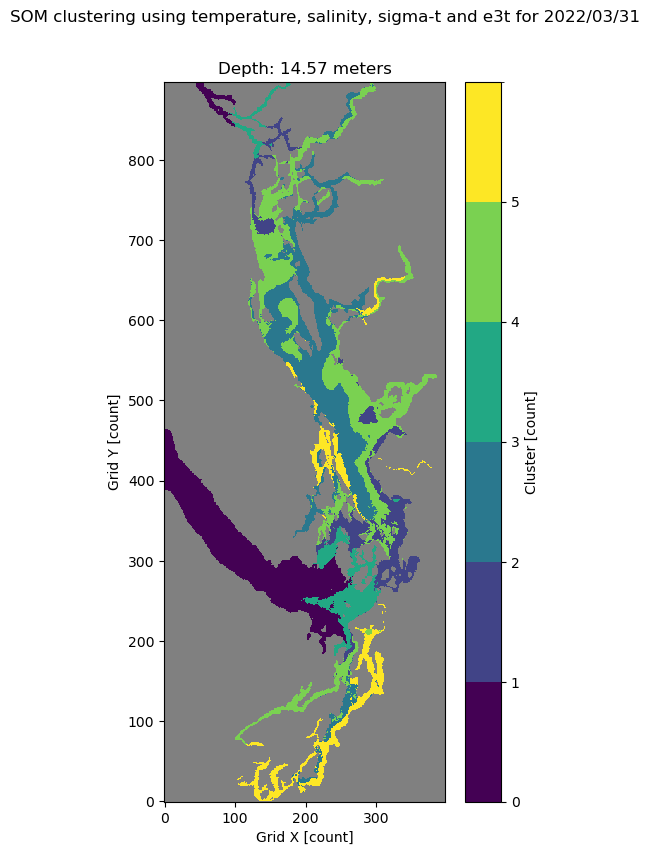

The amount of grid boxes for cluster 0 is 4828 

The minimum temperature for cluster 0 is 6.8 degrees Celsius
The maximum temperature for cluster 0 is 8.28 degrees Celsius
The mean temperature for cluster 0 is 7.87 degrees Celsius 

The minimum salinity for cluster 0 is 29.68 g/kg
The maximum salinity for cluster 0 is 30.26 g/kg
The mean salinity for cluster 0 is 30.0 g/kg 


The amount of grid boxes for cluster 1 is 15040 

The minimum temperature for cluster 1 is 7.72 degrees Celsius
The maximum temperature for cluster 1 is 8.67 degrees Celsius
The mean temperature for cluster 1 is 8.15 degrees Celsius 

The minimum salinity for cluster 1 is 28.96 g/kg
The maximum salinity for cluster 1 is 29.45 g/kg
The mean salinity for cluster 1 is 29.2 g/kg 


The amount of grid boxes for cluster 2 is 23678 

The minimum temperature for cluster 2 is 6.42 degrees Celsius
The maximum temperature for cluster 2 is 9.15 degrees Celsius
The mean temperature for cluster 2 is 7.98 degrees Celsius 

The m

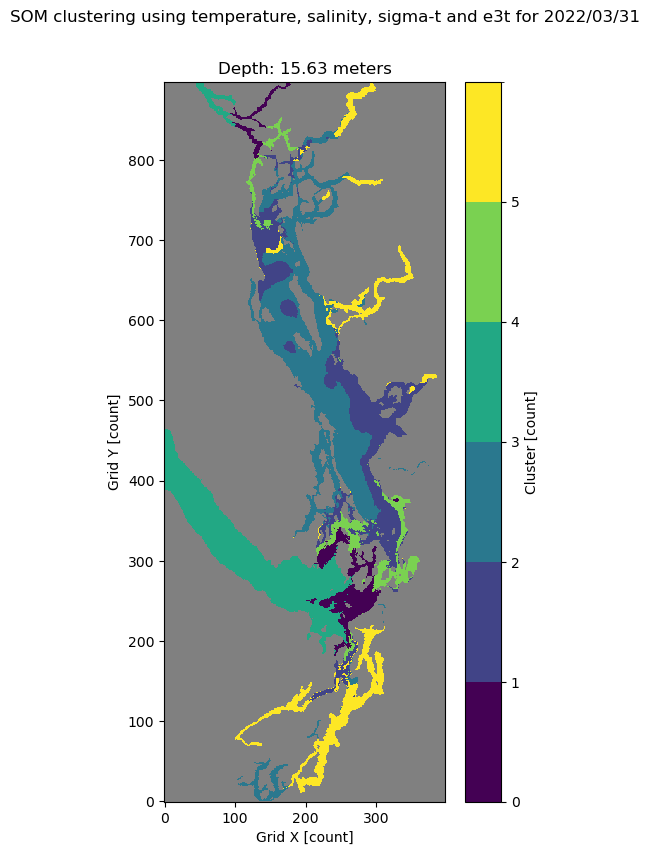

The amount of grid boxes for cluster 0 is 23317 

The minimum temperature for cluster 0 is 6.48 degrees Celsius
The maximum temperature for cluster 0 is 9.14 degrees Celsius
The mean temperature for cluster 0 is 7.98 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 29.12 g/kg
The mean salinity for cluster 0 is 28.68 g/kg 


The amount of grid boxes for cluster 1 is 5467 

The minimum temperature for cluster 1 is 7.56 degrees Celsius
The maximum temperature for cluster 1 is 8.4 degrees Celsius
The mean temperature for cluster 1 is 7.96 degrees Celsius 

The minimum salinity for cluster 1 is 29.22 g/kg
The maximum salinity for cluster 1 is 29.87 g/kg
The mean salinity for cluster 1 is 29.56 g/kg 


The amount of grid boxes for cluster 2 is 16152 

The minimum temperature for cluster 2 is 7.17 degrees Celsius
The maximum temperature for cluster 2 is 8.22 degrees Celsius
The mean temperature for cluster 2 is 7.8 degrees Celsius 

The mi

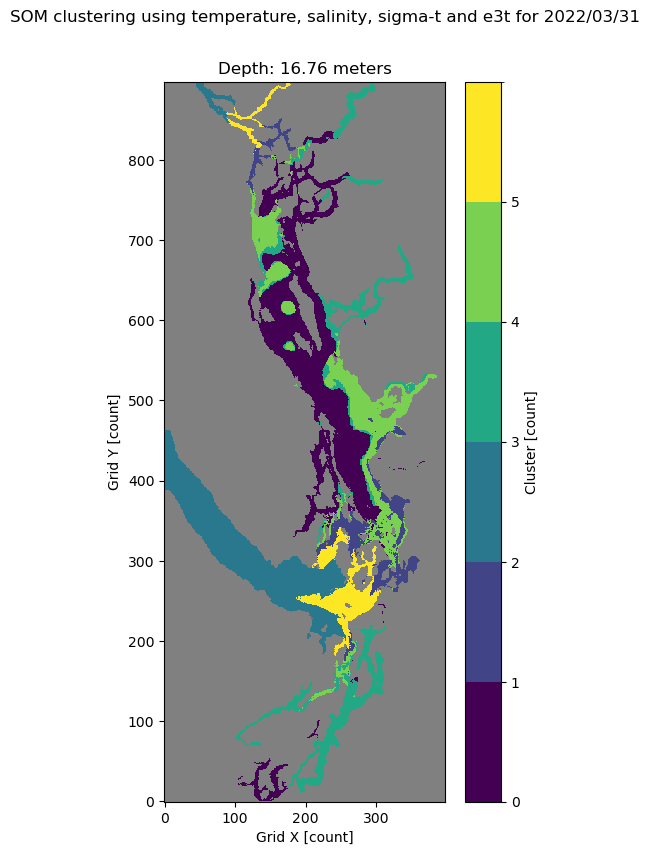

The amount of grid boxes for cluster 0 is 8763 

The minimum temperature for cluster 0 is 8.25 degrees Celsius
The maximum temperature for cluster 0 is 10.42 degrees Celsius
The mean temperature for cluster 0 is 8.92 degrees Celsius 

The minimum salinity for cluster 0 is 28.07 g/kg
The maximum salinity for cluster 0 is 29.67 g/kg
The mean salinity for cluster 0 is 29.04 g/kg 


The amount of grid boxes for cluster 1 is 4145 

The minimum temperature for cluster 1 is 7.57 degrees Celsius
The maximum temperature for cluster 1 is 8.67 degrees Celsius
The mean temperature for cluster 1 is 7.97 degrees Celsius 

The minimum salinity for cluster 1 is 29.52 g/kg
The maximum salinity for cluster 1 is 29.97 g/kg
The mean salinity for cluster 1 is 29.67 g/kg 


The amount of grid boxes for cluster 2 is 15693 

The minimum temperature for cluster 2 is 7.16 degrees Celsius
The maximum temperature for cluster 2 is 8.22 degrees Celsius
The mean temperature for cluster 2 is 7.78 degrees Celsius 

Th

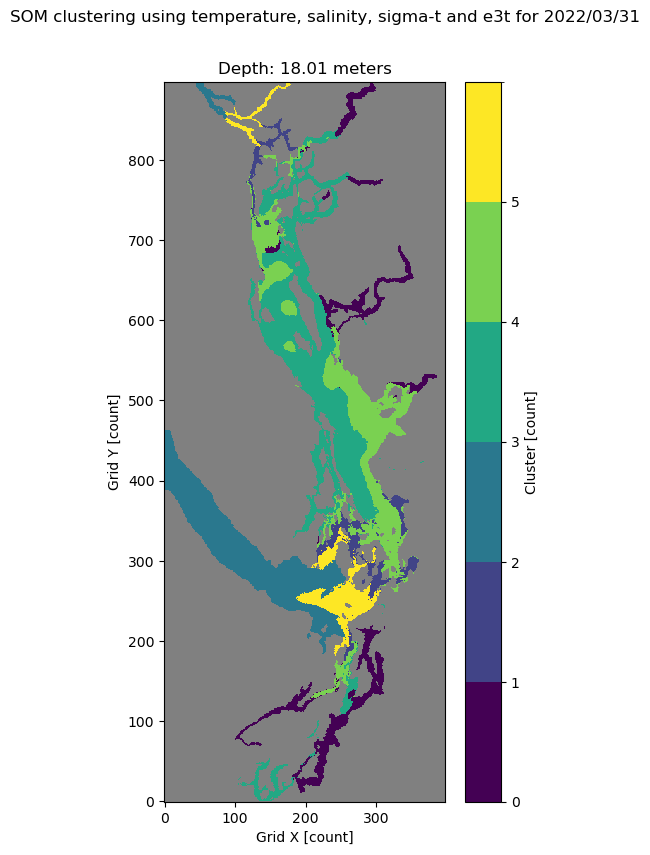

The amount of grid boxes for cluster 0 is 8810 

The minimum temperature for cluster 0 is 8.26 degrees Celsius
The maximum temperature for cluster 0 is 10.33 degrees Celsius
The mean temperature for cluster 0 is 8.93 degrees Celsius 

The minimum salinity for cluster 0 is 28.17 g/kg
The maximum salinity for cluster 0 is 29.76 g/kg
The mean salinity for cluster 0 is 29.11 g/kg 


The amount of grid boxes for cluster 1 is 4296 

The minimum temperature for cluster 1 is 7.58 degrees Celsius
The maximum temperature for cluster 1 is 8.67 degrees Celsius
The mean temperature for cluster 1 is 8.01 degrees Celsius 

The minimum salinity for cluster 1 is 29.51 g/kg
The maximum salinity for cluster 1 is 29.92 g/kg
The mean salinity for cluster 1 is 29.63 g/kg 


The amount of grid boxes for cluster 2 is 16437 

The minimum temperature for cluster 2 is 7.15 degrees Celsius
The maximum temperature for cluster 2 is 8.18 degrees Celsius
The mean temperature for cluster 2 is 7.77 degrees Celsius 

Th

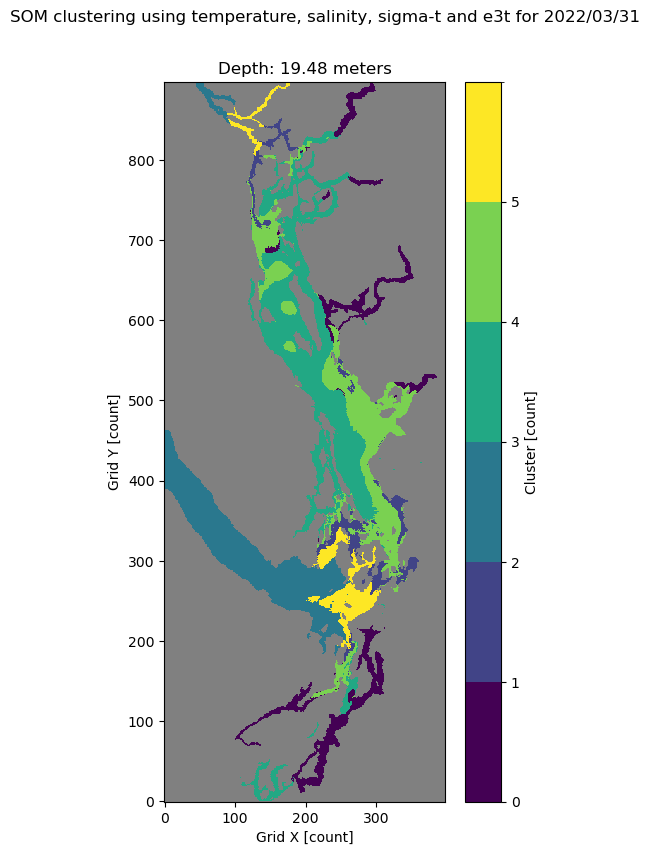

The amount of grid boxes for cluster 0 is 19911 

The minimum temperature for cluster 0 is 7.34 degrees Celsius
The maximum temperature for cluster 0 is 9.04 degrees Celsius
The mean temperature for cluster 0 is 8.05 degrees Celsius 

The minimum salinity for cluster 0 is 23.37 g/kg
The maximum salinity for cluster 0 is 29.15 g/kg
The mean salinity for cluster 0 is 28.83 g/kg 


The amount of grid boxes for cluster 1 is 13977 

The minimum temperature for cluster 1 is 7.75 degrees Celsius
The maximum temperature for cluster 1 is 9.13 degrees Celsius
The mean temperature for cluster 1 is 8.19 degrees Celsius 

The minimum salinity for cluster 1 is 29.16 g/kg
The maximum salinity for cluster 1 is 29.67 g/kg
The mean salinity for cluster 1 is 29.42 g/kg 


The amount of grid boxes for cluster 2 is 4472 

The minimum temperature for cluster 2 is 7.28 degrees Celsius
The maximum temperature for cluster 2 is 8.14 degrees Celsius
The mean temperature for cluster 2 is 7.85 degrees Celsius 

Th

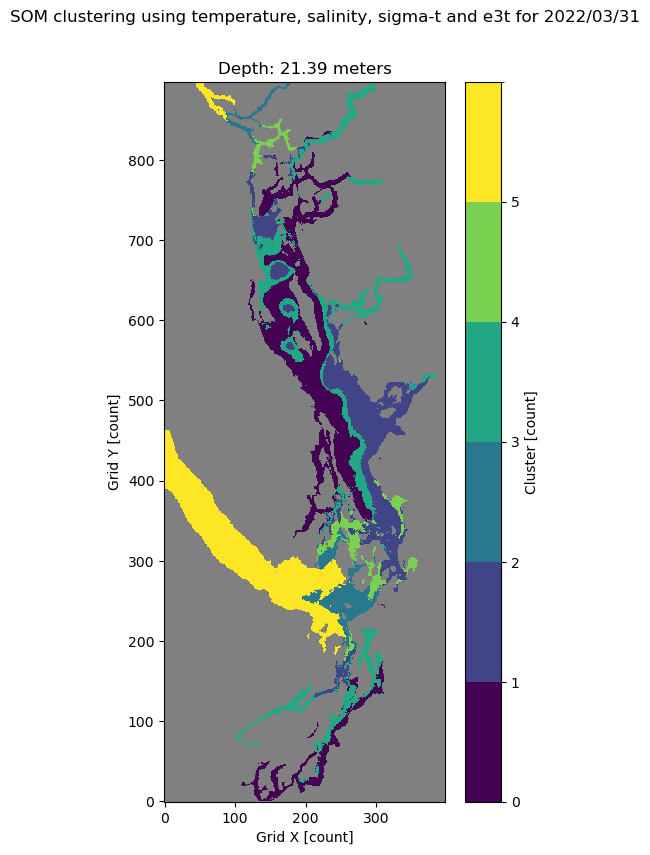

The amount of grid boxes for cluster 0 is 4531 

The minimum temperature for cluster 0 is 7.28 degrees Celsius
The maximum temperature for cluster 0 is 8.28 degrees Celsius
The mean temperature for cluster 0 is 7.84 degrees Celsius 

The minimum salinity for cluster 0 is 29.96 g/kg
The maximum salinity for cluster 0 is 30.57 g/kg
The mean salinity for cluster 0 is 30.26 g/kg 


The amount of grid boxes for cluster 1 is 10955 

The minimum temperature for cluster 1 is 7.91 degrees Celsius
The maximum temperature for cluster 1 is 9.38 degrees Celsius
The mean temperature for cluster 1 is 8.27 degrees Celsius 

The minimum salinity for cluster 1 is 29.35 g/kg
The maximum salinity for cluster 1 is 29.9 g/kg
The mean salinity for cluster 1 is 29.51 g/kg 


The amount of grid boxes for cluster 2 is 10145 

The minimum temperature for cluster 2 is 8.19 degrees Celsius
The maximum temperature for cluster 2 is 10.2 degrees Celsius
The mean temperature for cluster 2 is 8.84 degrees Celsius 

The

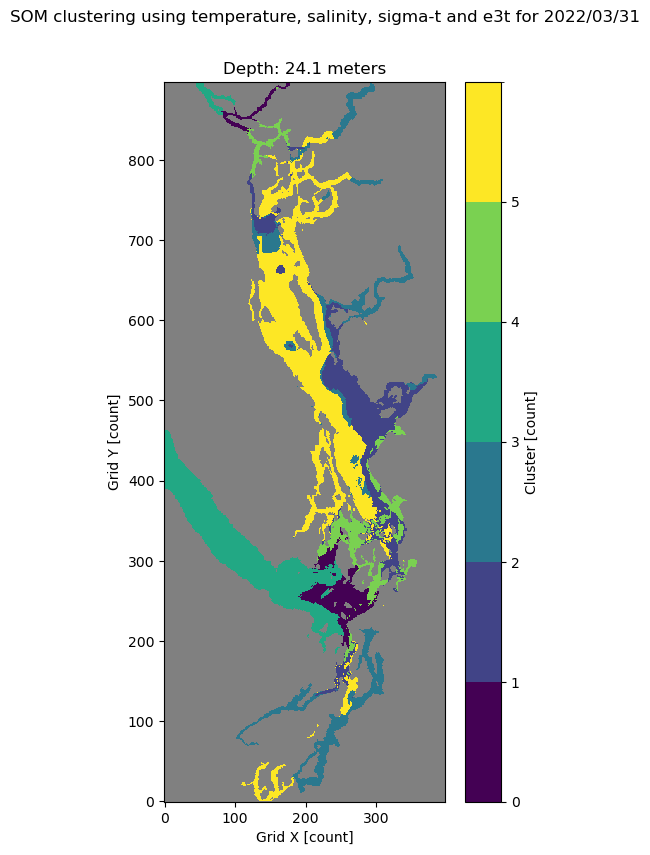

The amount of grid boxes for cluster 0 is 3153 

The minimum temperature for cluster 0 is 7.57 degrees Celsius
The maximum temperature for cluster 0 is 8.01 degrees Celsius
The mean temperature for cluster 0 is 7.81 degrees Celsius 

The minimum salinity for cluster 0 is 30.25 g/kg
The maximum salinity for cluster 0 is 30.72 g/kg
The mean salinity for cluster 0 is 30.48 g/kg 


The amount of grid boxes for cluster 1 is 10558 

The minimum temperature for cluster 1 is 8.02 degrees Celsius
The maximum temperature for cluster 1 is 10.21 degrees Celsius
The mean temperature for cluster 1 is 8.79 degrees Celsius 

The minimum salinity for cluster 1 is 29.31 g/kg
The maximum salinity for cluster 1 is 29.97 g/kg
The mean salinity for cluster 1 is 29.66 g/kg 


The amount of grid boxes for cluster 2 is 16821 

The minimum temperature for cluster 2 is 7.34 degrees Celsius
The maximum temperature for cluster 2 is 10.19 degrees Celsius
The mean temperature for cluster 2 is 8.25 degrees Celsius 



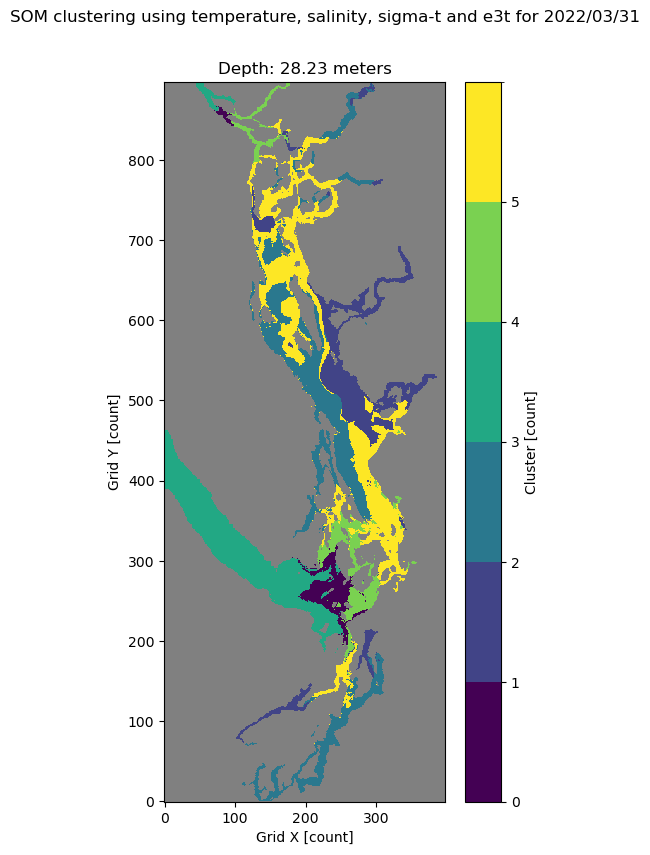

The amount of grid boxes for cluster 0 is 17478 

The minimum temperature for cluster 0 is 7.32 degrees Celsius
The maximum temperature for cluster 0 is 10.2 degrees Celsius
The mean temperature for cluster 0 is 8.16 degrees Celsius 

The minimum salinity for cluster 0 is 26.82 g/kg
The maximum salinity for cluster 0 is 30.8 g/kg
The mean salinity for cluster 0 is 29.23 g/kg 


The amount of grid boxes for cluster 1 is 10129 

The minimum temperature for cluster 1 is 7.34 degrees Celsius
The maximum temperature for cluster 1 is 8.36 degrees Celsius
The mean temperature for cluster 1 is 7.99 degrees Celsius 

The minimum salinity for cluster 1 is 29.39 g/kg
The maximum salinity for cluster 1 is 30.28 g/kg
The mean salinity for cluster 1 is 29.69 g/kg 


The amount of grid boxes for cluster 2 is 4585 

The minimum temperature for cluster 2 is 7.13 degrees Celsius
The maximum temperature for cluster 2 is 7.97 degrees Celsius
The mean temperature for cluster 2 is 7.75 degrees Celsius 

The

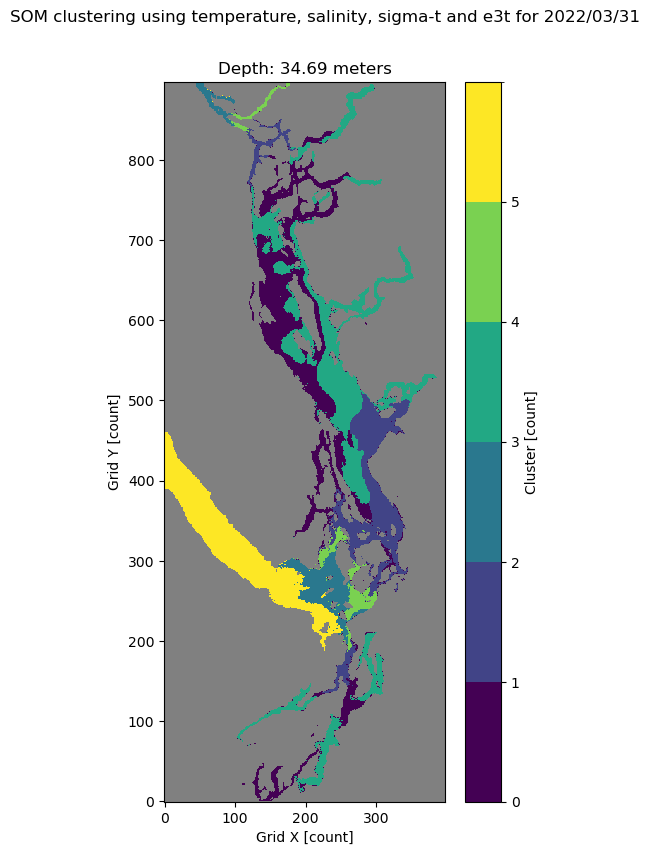

The amount of grid boxes for cluster 0 is 14491 

The minimum temperature for cluster 0 is 7.13 degrees Celsius
The maximum temperature for cluster 0 is 7.85 degrees Celsius
The mean temperature for cluster 0 is 7.59 degrees Celsius 

The minimum salinity for cluster 0 is 30.6 g/kg
The maximum salinity for cluster 0 is 32.93 g/kg
The mean salinity for cluster 0 is 31.51 g/kg 


The amount of grid boxes for cluster 1 is 6992 

The minimum temperature for cluster 1 is 7.43 degrees Celsius
The maximum temperature for cluster 1 is 9.02 degrees Celsius
The mean temperature for cluster 1 is 7.88 degrees Celsius 

The minimum salinity for cluster 1 is 29.68 g/kg
The maximum salinity for cluster 1 is 30.66 g/kg
The mean salinity for cluster 1 is 30.07 g/kg 


The amount of grid boxes for cluster 2 is 36186 

The minimum temperature for cluster 2 is 7.66 degrees Celsius
The maximum temperature for cluster 2 is 10.31 degrees Celsius
The mean temperature for cluster 2 is 8.45 degrees Celsius 

Th

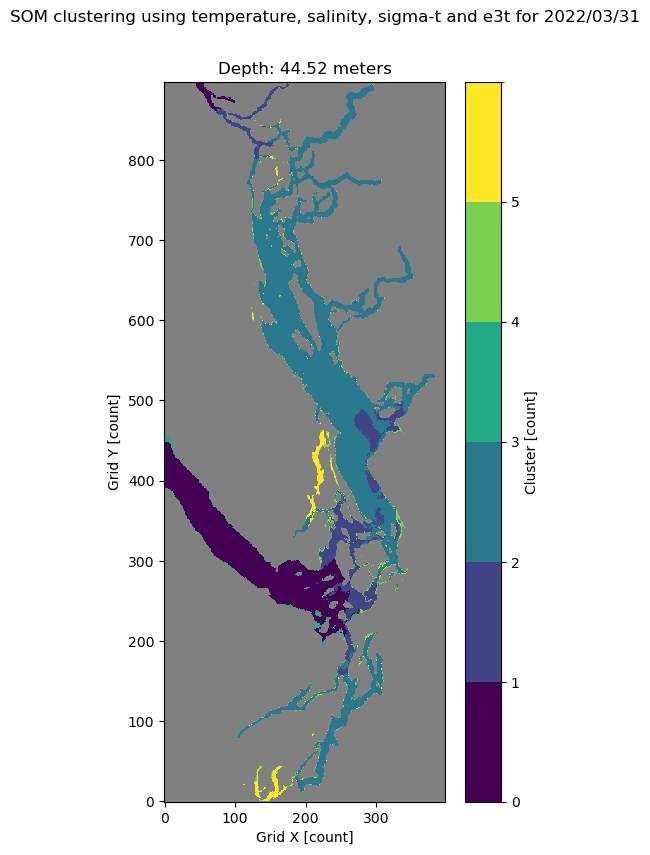

The amount of grid boxes for cluster 0 is 13676 

The minimum temperature for cluster 0 is 7.16 degrees Celsius
The maximum temperature for cluster 0 is 7.8 degrees Celsius
The mean temperature for cluster 0 is 7.51 degrees Celsius 

The minimum salinity for cluster 0 is 30.73 g/kg
The maximum salinity for cluster 0 is 33.17 g/kg
The mean salinity for cluster 0 is 31.86 g/kg 


The amount of grid boxes for cluster 1 is 3339 

The minimum temperature for cluster 1 is 7.43 degrees Celsius
The maximum temperature for cluster 1 is 8.45 degrees Celsius
The mean temperature for cluster 1 is 7.78 degrees Celsius 

The minimum salinity for cluster 1 is 29.81 g/kg
The maximum salinity for cluster 1 is 30.78 g/kg
The mean salinity for cluster 1 is 30.26 g/kg 


The amount of grid boxes for cluster 2 is 36632 

The minimum temperature for cluster 2 is 7.62 degrees Celsius
The maximum temperature for cluster 2 is 10.39 degrees Celsius
The mean temperature for cluster 2 is 8.47 degrees Celsius 

Th

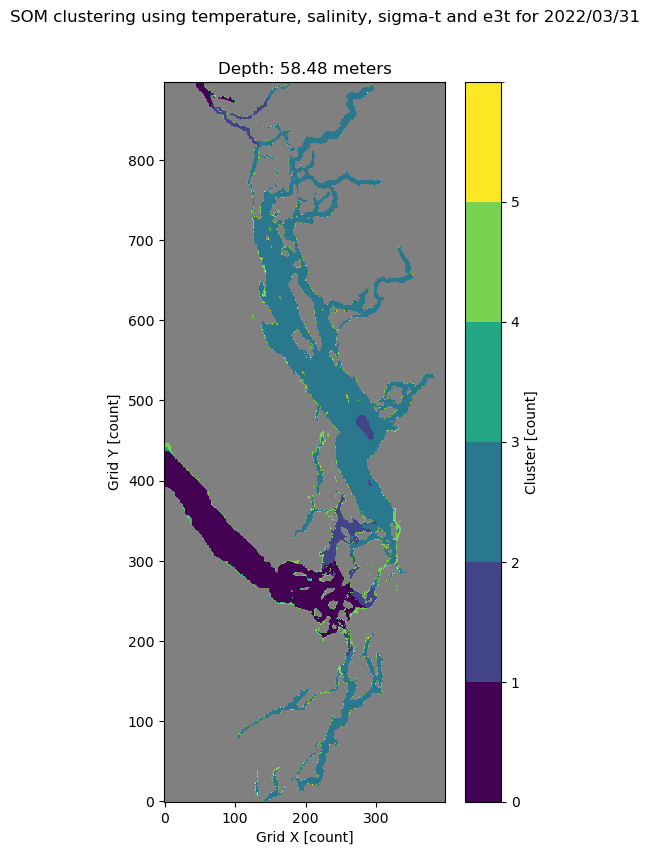

The amount of grid boxes for cluster 0 is 4456 

The minimum temperature for cluster 0 is 7.2 degrees Celsius
The maximum temperature for cluster 0 is 10.45 degrees Celsius
The mean temperature for cluster 0 is 8.05 degrees Celsius 

The minimum salinity for cluster 0 is 27.51 g/kg
The maximum salinity for cluster 0 is 33.3 g/kg
The mean salinity for cluster 0 is 30.49 g/kg 


The amount of grid boxes for cluster 1 is 501 

The minimum temperature for cluster 1 is 7.43 degrees Celsius
The maximum temperature for cluster 1 is 10.29 degrees Celsius
The mean temperature for cluster 1 is 8.34 degrees Celsius 

The minimum salinity for cluster 1 is 29.0 g/kg
The maximum salinity for cluster 1 is 31.12 g/kg
The mean salinity for cluster 1 is 30.0 g/kg 


The amount of grid boxes for cluster 2 is 33756 

The minimum temperature for cluster 2 is 7.62 degrees Celsius
The maximum temperature for cluster 2 is 10.45 degrees Celsius
The mean temperature for cluster 2 is 8.48 degrees Celsius 

The m

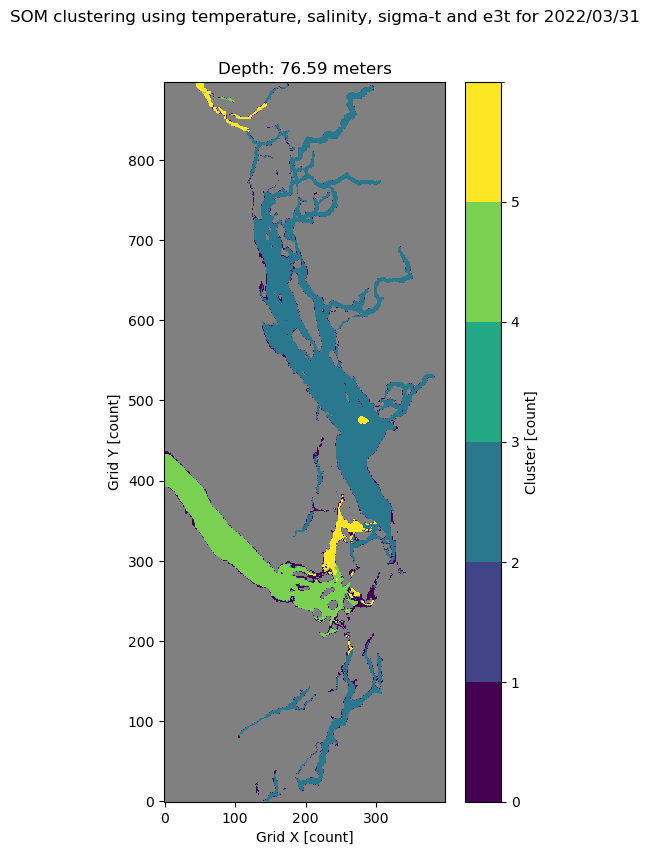

The amount of grid boxes for cluster 0 is 503 

The minimum temperature for cluster 0 is 7.09 degrees Celsius
The maximum temperature for cluster 0 is 9.37 degrees Celsius
The mean temperature for cluster 0 is 7.55 degrees Celsius 

The minimum salinity for cluster 0 is 29.89 g/kg
The maximum salinity for cluster 0 is 33.44 g/kg
The mean salinity for cluster 0 is 31.96 g/kg 


The amount of grid boxes for cluster 1 is 9154 

The minimum temperature for cluster 1 is 7.07 degrees Celsius
The maximum temperature for cluster 1 is 7.62 degrees Celsius
The mean temperature for cluster 1 is 7.25 degrees Celsius 

The minimum salinity for cluster 1 is 31.36 g/kg
The maximum salinity for cluster 1 is 33.55 g/kg
The mean salinity for cluster 1 is 32.97 g/kg 


The amount of grid boxes for cluster 2 is 1568 

The minimum temperature for cluster 2 is 7.28 degrees Celsius
The maximum temperature for cluster 2 is 7.89 degrees Celsius
The mean temperature for cluster 2 is 7.66 degrees Celsius 

The m

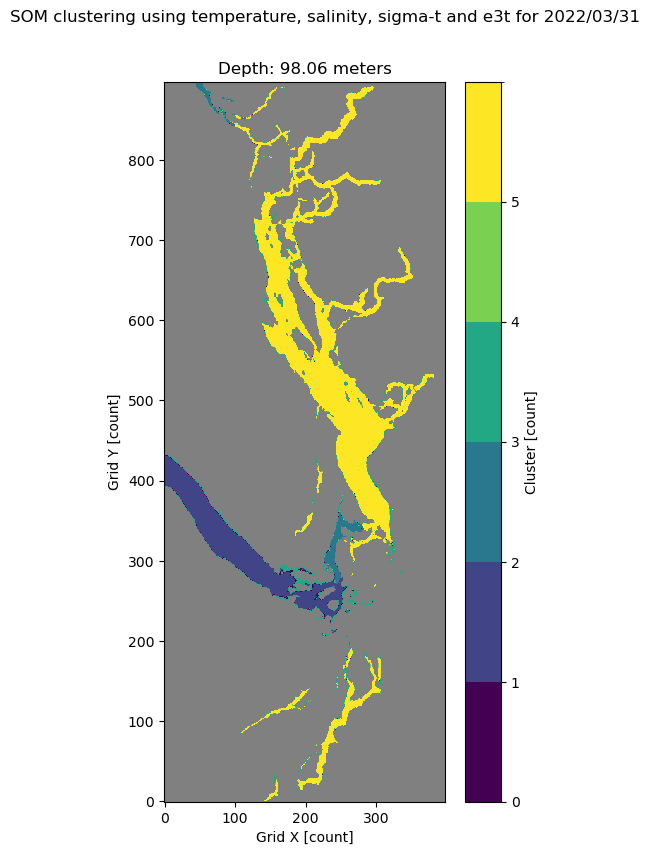

The amount of grid boxes for cluster 0 is 12946 

The minimum temperature for cluster 0 is 7.29 degrees Celsius
The maximum temperature for cluster 0 is 8.35 degrees Celsius
The mean temperature for cluster 0 is 7.93 degrees Celsius 

The minimum salinity for cluster 0 is 29.65 g/kg
The maximum salinity for cluster 0 is 31.18 g/kg
The mean salinity for cluster 0 is 30.27 g/kg 


The amount of grid boxes for cluster 1 is 7348 

The minimum temperature for cluster 1 is 6.94 degrees Celsius
The maximum temperature for cluster 1 is 7.68 degrees Celsius
The mean temperature for cluster 1 is 7.17 degrees Celsius 

The minimum salinity for cluster 1 is 30.97 g/kg
The maximum salinity for cluster 1 is 33.68 g/kg
The mean salinity for cluster 1 is 33.24 g/kg 


The amount of grid boxes for cluster 2 is 896 

The minimum temperature for cluster 2 is 6.98 degrees Celsius
The maximum temperature for cluster 2 is 10.57 degrees Celsius
The mean temperature for cluster 2 is 7.87 degrees Celsius 

The

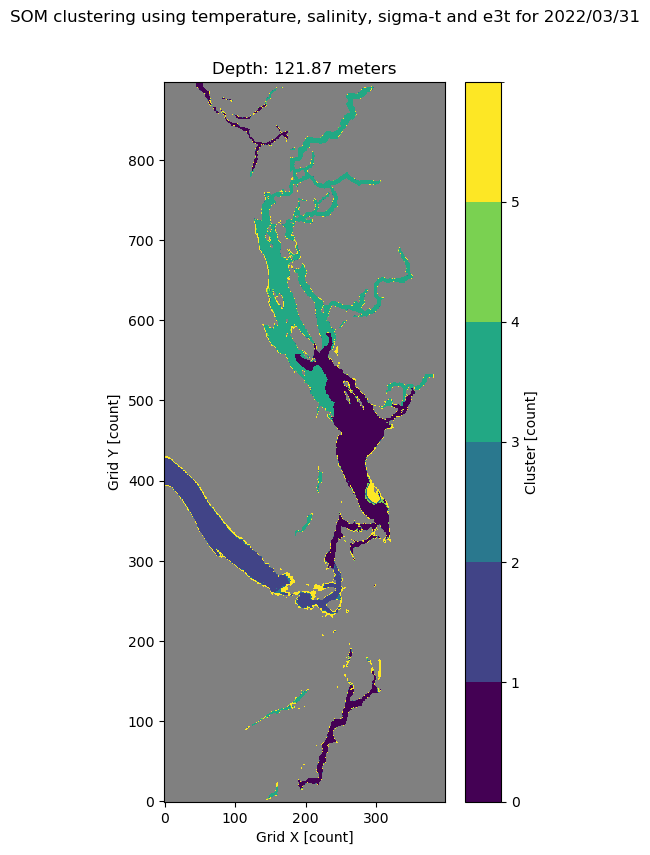

The amount of grid boxes for cluster 0 is 2710 

The minimum temperature for cluster 0 is 6.94 degrees Celsius
The maximum temperature for cluster 0 is 10.73 degrees Celsius
The mean temperature for cluster 0 is 8.01 degrees Celsius 

The minimum salinity for cluster 0 is 28.18 g/kg
The maximum salinity for cluster 0 is 33.7 g/kg
The mean salinity for cluster 0 is 31.33 g/kg 


The amount of grid boxes for cluster 1 is 1171 

The minimum temperature for cluster 1 is 6.91 degrees Celsius
The maximum temperature for cluster 1 is 10.5 degrees Celsius
The mean temperature for cluster 1 is 7.93 degrees Celsius 

The minimum salinity for cluster 1 is 28.2 g/kg
The maximum salinity for cluster 1 is 33.72 g/kg
The mean salinity for cluster 1 is 31.47 g/kg 


The amount of grid boxes for cluster 2 is 5645 

The minimum temperature for cluster 2 is 6.83 degrees Celsius
The maximum temperature for cluster 2 is 7.68 degrees Celsius
The mean temperature for cluster 2 is 7.13 degrees Celsius 

The m

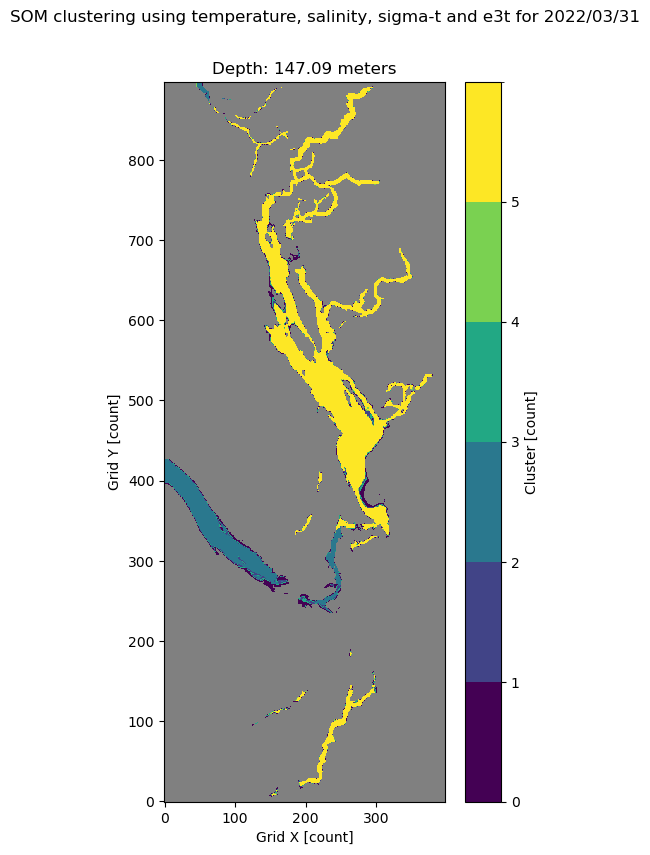

The amount of grid boxes for cluster 0 is 3003 

The minimum temperature for cluster 0 is 6.72 degrees Celsius
The maximum temperature for cluster 0 is 7.68 degrees Celsius
The mean temperature for cluster 0 is 7.03 degrees Celsius 

The minimum salinity for cluster 0 is 31.06 g/kg
The maximum salinity for cluster 0 is 33.84 g/kg
The mean salinity for cluster 0 is 33.31 g/kg 


The amount of grid boxes for cluster 1 is 875 

The minimum temperature for cluster 1 is 6.82 degrees Celsius
The maximum temperature for cluster 1 is 9.73 degrees Celsius
The mean temperature for cluster 1 is 7.64 degrees Celsius 

The minimum salinity for cluster 1 is 29.81 g/kg
The maximum salinity for cluster 1 is 33.78 g/kg
The mean salinity for cluster 1 is 32.26 g/kg 


The amount of grid boxes for cluster 2 is 1590 

The minimum temperature for cluster 2 is 6.84 degrees Celsius
The maximum temperature for cluster 2 is 10.8 degrees Celsius
The mean temperature for cluster 2 is 7.97 degrees Celsius 

The m

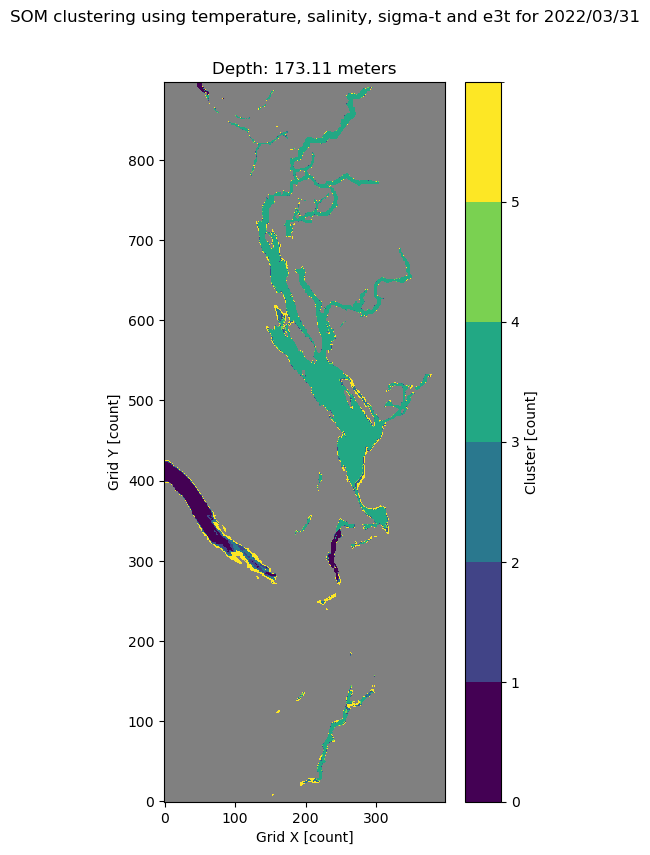

The amount of grid boxes for cluster 0 is 14904 

The minimum temperature for cluster 0 is 7.44 degrees Celsius
The maximum temperature for cluster 0 is 9.92 degrees Celsius
The mean temperature for cluster 0 is 8.86 degrees Celsius 

The minimum salinity for cluster 0 is 29.16 g/kg
The maximum salinity for cluster 0 is 31.0 g/kg
The mean salinity for cluster 0 is 30.7 g/kg 


The amount of grid boxes for cluster 1 is 256 

The minimum temperature for cluster 1 is 7.44 degrees Celsius
The maximum temperature for cluster 1 is 9.86 degrees Celsius
The mean temperature for cluster 1 is 8.64 degrees Celsius 

The minimum salinity for cluster 1 is 29.77 g/kg
The maximum salinity for cluster 1 is 31.88 g/kg
The mean salinity for cluster 1 is 30.59 g/kg 


The amount of grid boxes for cluster 2 is 1126 

The minimum temperature for cluster 2 is 6.68 degrees Celsius
The maximum temperature for cluster 2 is 9.92 degrees Celsius
The mean temperature for cluster 2 is 8.1 degrees Celsius 

The min

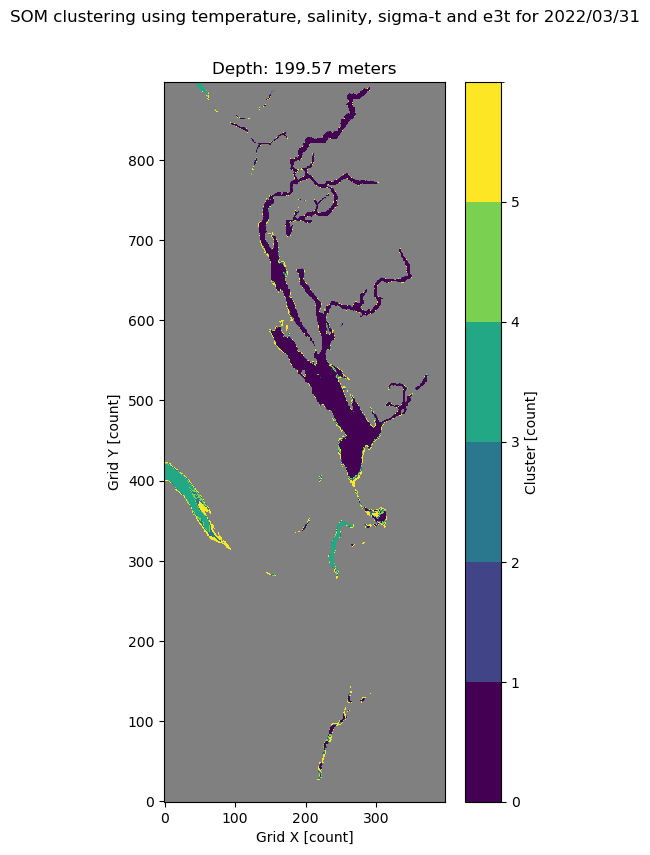

The amount of grid boxes for cluster 0 is 617 

The minimum temperature for cluster 0 is 6.51 degrees Celsius
The maximum temperature for cluster 0 is 9.4 degrees Celsius
The mean temperature for cluster 0 is 8.33 degrees Celsius 

The minimum salinity for cluster 0 is 29.77 g/kg
The maximum salinity for cluster 0 is 33.93 g/kg
The mean salinity for cluster 0 is 31.41 g/kg 


The amount of grid boxes for cluster 1 is 190 

The minimum temperature for cluster 1 is 6.58 degrees Celsius
The maximum temperature for cluster 1 is 9.4 degrees Celsius
The mean temperature for cluster 1 is 8.65 degrees Celsius 

The minimum salinity for cluster 1 is 29.81 g/kg
The maximum salinity for cluster 1 is 33.89 g/kg
The mean salinity for cluster 1 is 31.04 g/kg 


The amount of grid boxes for cluster 2 is 9181 

The minimum temperature for cluster 2 is 8.73 degrees Celsius
The maximum temperature for cluster 2 is 9.68 degrees Celsius
The mean temperature for cluster 2 is 9.2 degrees Celsius 

The minim

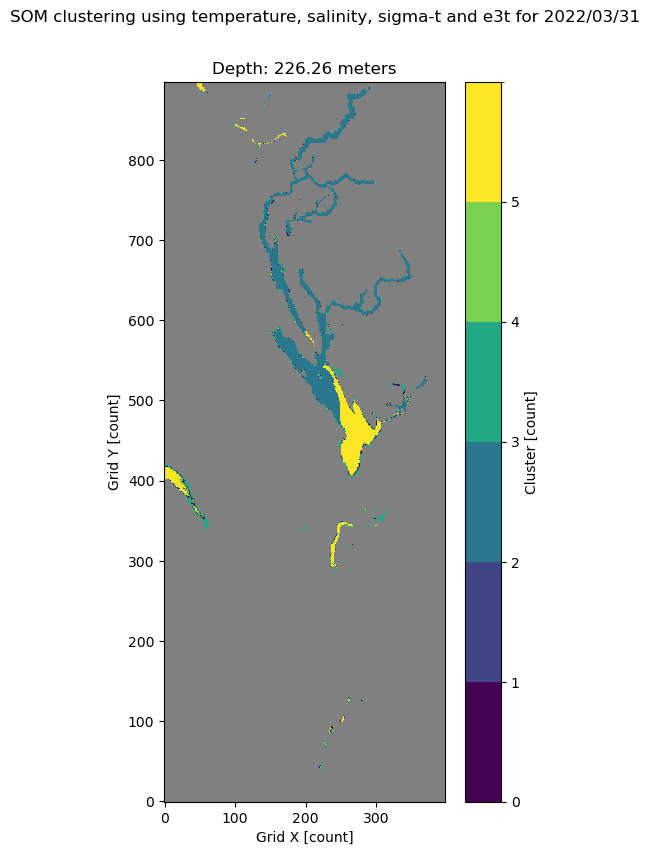

The amount of grid boxes for cluster 0 is 4577 

The minimum temperature for cluster 0 is 6.43 degrees Celsius
The maximum temperature for cluster 0 is 9.34 degrees Celsius
The mean temperature for cluster 0 is 8.75 degrees Celsius 

The minimum salinity for cluster 0 is 29.83 g/kg
The maximum salinity for cluster 0 is 33.96 g/kg
The mean salinity for cluster 0 is 30.83 g/kg 


The amount of grid boxes for cluster 1 is 403 

The minimum temperature for cluster 1 is 6.43 degrees Celsius
The maximum temperature for cluster 1 is 9.41 degrees Celsius
The mean temperature for cluster 1 is 8.76 degrees Celsius 

The minimum salinity for cluster 1 is 29.83 g/kg
The maximum salinity for cluster 1 is 33.96 g/kg
The mean salinity for cluster 1 is 31.11 g/kg 


The amount of grid boxes for cluster 2 is 1246 

The minimum temperature for cluster 2 is 6.43 degrees Celsius
The maximum temperature for cluster 2 is 9.69 degrees Celsius
The mean temperature for cluster 2 is 8.54 degrees Celsius 

The m

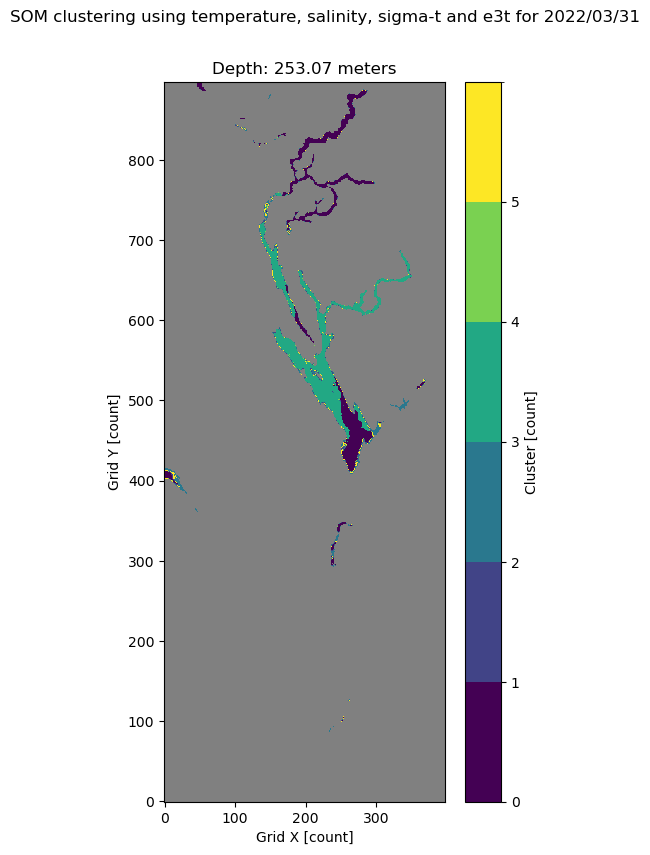

The amount of grid boxes for cluster 0 is 810 

The minimum temperature for cluster 0 is 6.39 degrees Celsius
The maximum temperature for cluster 0 is 9.41 degrees Celsius
The mean temperature for cluster 0 is 8.82 degrees Celsius 

The minimum salinity for cluster 0 is 29.84 g/kg
The maximum salinity for cluster 0 is 33.97 g/kg
The mean salinity for cluster 0 is 31.18 g/kg 


The amount of grid boxes for cluster 1 is 278 

The minimum temperature for cluster 1 is 7.53 degrees Celsius
The maximum temperature for cluster 1 is 9.41 degrees Celsius
The mean temperature for cluster 1 is 9.04 degrees Celsius 

The minimum salinity for cluster 1 is 29.84 g/kg
The maximum salinity for cluster 1 is 31.56 g/kg
The mean salinity for cluster 1 is 30.92 g/kg 


The amount of grid boxes for cluster 2 is 5229 

The minimum temperature for cluster 2 is 9.03 degrees Celsius
The maximum temperature for cluster 2 is 9.42 degrees Celsius
The mean temperature for cluster 2 is 9.33 degrees Celsius 

The mi

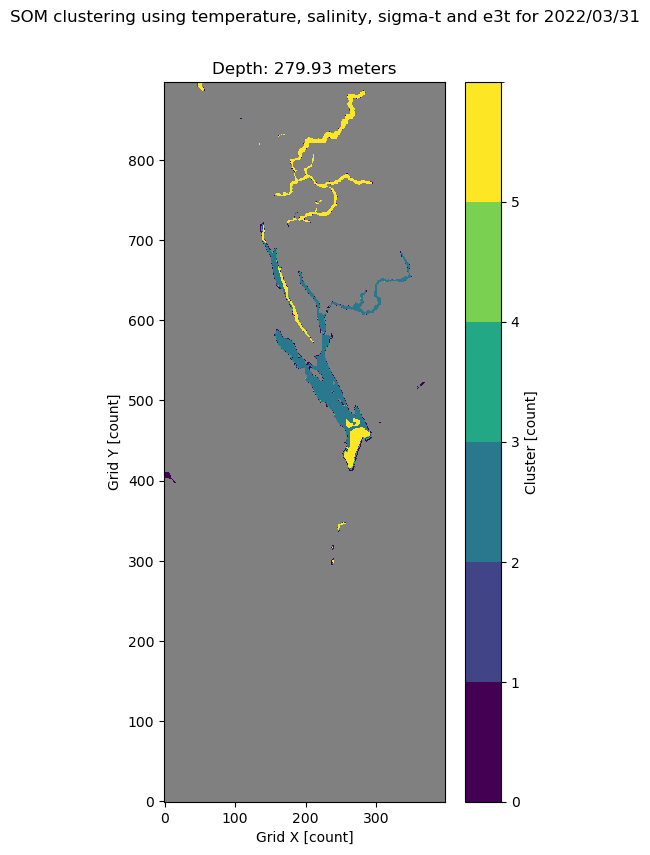

The amount of grid boxes for cluster 0 is 417 

The minimum temperature for cluster 0 is 7.53 degrees Celsius
The maximum temperature for cluster 0 is 9.42 degrees Celsius
The mean temperature for cluster 0 is 9.13 degrees Celsius 

The minimum salinity for cluster 0 is 30.6 g/kg
The maximum salinity for cluster 0 is 31.57 g/kg
The mean salinity for cluster 0 is 30.97 g/kg 


The amount of grid boxes for cluster 1 is 143 

The minimum temperature for cluster 1 is 7.53 degrees Celsius
The maximum temperature for cluster 1 is 9.42 degrees Celsius
The mean temperature for cluster 1 is 9.13 degrees Celsius 

The minimum salinity for cluster 1 is 29.95 g/kg
The maximum salinity for cluster 1 is 31.58 g/kg
The mean salinity for cluster 1 is 30.99 g/kg 


The amount of grid boxes for cluster 2 is 4462 

The minimum temperature for cluster 2 is 8.99 degrees Celsius
The maximum temperature for cluster 2 is 9.44 degrees Celsius
The mean temperature for cluster 2 is 9.36 degrees Celsius 

The min

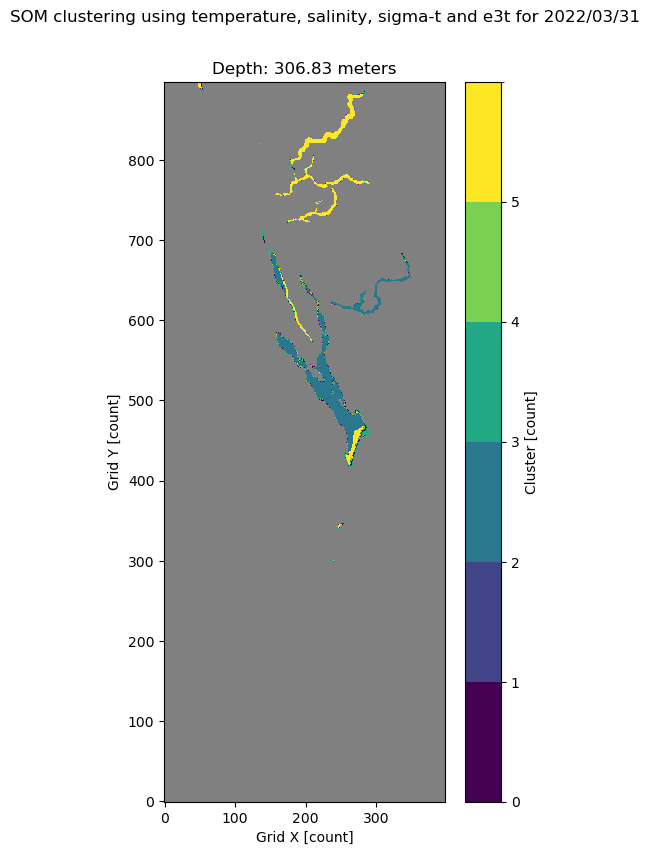

The amount of grid boxes for cluster 0 is 73 

The minimum temperature for cluster 0 is 8.76 degrees Celsius
The maximum temperature for cluster 0 is 9.44 degrees Celsius
The mean temperature for cluster 0 is 9.3 degrees Celsius 

The minimum salinity for cluster 0 is 30.7 g/kg
The maximum salinity for cluster 0 is 31.16 g/kg
The mean salinity for cluster 0 is 31.03 g/kg 


The amount of grid boxes for cluster 1 is 333 

The minimum temperature for cluster 1 is 7.6 degrees Celsius
The maximum temperature for cluster 1 is 9.44 degrees Celsius
The mean temperature for cluster 1 is 9.24 degrees Celsius 

The minimum salinity for cluster 1 is 30.57 g/kg
The maximum salinity for cluster 1 is 31.23 g/kg
The mean salinity for cluster 1 is 31.02 g/kg 


The amount of grid boxes for cluster 2 is 752 

The minimum temperature for cluster 2 is 7.6 degrees Celsius
The maximum temperature for cluster 2 is 9.43 degrees Celsius
The mean temperature for cluster 2 is 9.16 degrees Celsius 

The minimum 

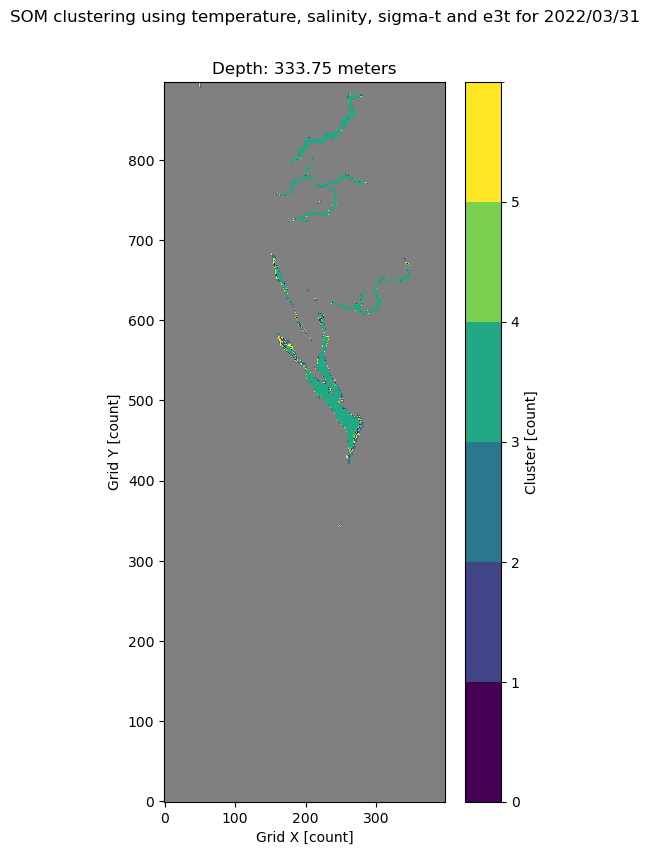

The amount of grid boxes for cluster 0 is 548 

The minimum temperature for cluster 0 is 8.9 degrees Celsius
The maximum temperature for cluster 0 is 9.45 degrees Celsius
The mean temperature for cluster 0 is 9.34 degrees Celsius 

The minimum salinity for cluster 0 is 30.68 g/kg
The maximum salinity for cluster 0 is 31.17 g/kg
The mean salinity for cluster 0 is 31.04 g/kg 


The amount of grid boxes for cluster 1 is 259 

The minimum temperature for cluster 1 is 8.93 degrees Celsius
The maximum temperature for cluster 1 is 9.45 degrees Celsius
The mean temperature for cluster 1 is 9.27 degrees Celsius 

The minimum salinity for cluster 1 is 30.68 g/kg
The maximum salinity for cluster 1 is 31.17 g/kg
The mean salinity for cluster 1 is 31.0 g/kg 


The amount of grid boxes for cluster 2 is 35 

The minimum temperature for cluster 2 is 8.96 degrees Celsius
The maximum temperature for cluster 2 is 9.45 degrees Celsius
The mean temperature for cluster 2 is 9.27 degrees Celsius 

The minimu

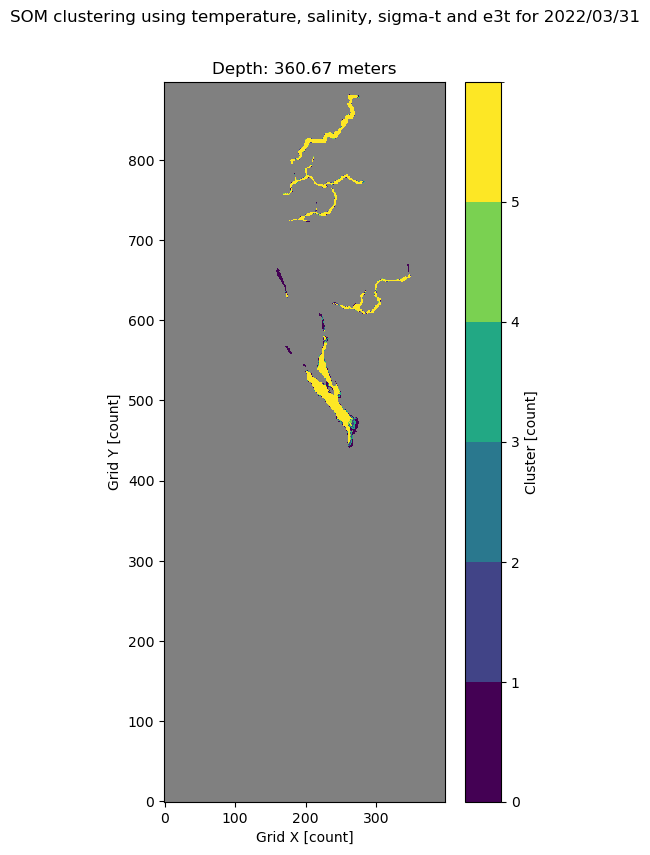

The amount of grid boxes for cluster 0 is 2480 

The minimum temperature for cluster 0 is 8.92 degrees Celsius
The maximum temperature for cluster 0 is 9.45 degrees Celsius
The mean temperature for cluster 0 is 9.19 degrees Celsius 

The minimum salinity for cluster 0 is 30.68 g/kg
The maximum salinity for cluster 0 is 31.18 g/kg
The mean salinity for cluster 0 is 30.93 g/kg 


The amount of grid boxes for cluster 1 is 151 

The minimum temperature for cluster 1 is 8.93 degrees Celsius
The maximum temperature for cluster 1 is 9.45 degrees Celsius
The mean temperature for cluster 1 is 9.36 degrees Celsius 

The minimum salinity for cluster 1 is 30.68 g/kg
The maximum salinity for cluster 1 is 31.18 g/kg
The mean salinity for cluster 1 is 31.09 g/kg 


The amount of grid boxes for cluster 2 is 207 

The minimum temperature for cluster 2 is 8.95 degrees Celsius
The maximum temperature for cluster 2 is 9.45 degrees Celsius
The mean temperature for cluster 2 is 9.38 degrees Celsius 

The mi

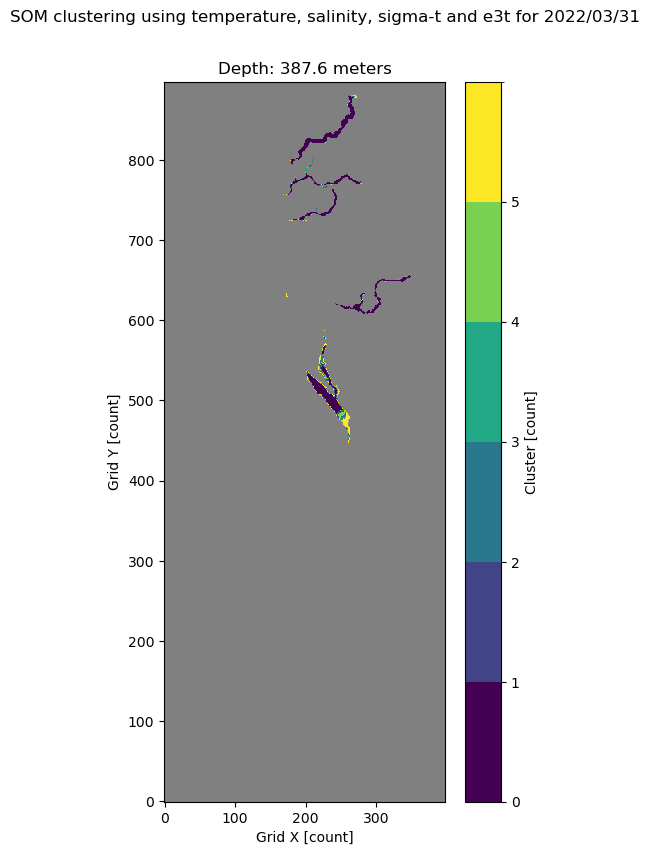

The amount of grid boxes for cluster 0 is 428 

The minimum temperature for cluster 0 is 8.92 degrees Celsius
The maximum temperature for cluster 0 is 9.45 degrees Celsius
The mean temperature for cluster 0 is 9.4 degrees Celsius 

The minimum salinity for cluster 0 is 30.68 g/kg
The maximum salinity for cluster 0 is 31.18 g/kg
The mean salinity for cluster 0 is 31.13 g/kg 


The amount of grid boxes for cluster 1 is 63 

The minimum temperature for cluster 1 is 8.92 degrees Celsius
The maximum temperature for cluster 1 is 9.44 degrees Celsius
The mean temperature for cluster 1 is 9.26 degrees Celsius 

The minimum salinity for cluster 1 is 30.68 g/kg
The maximum salinity for cluster 1 is 31.18 g/kg
The mean salinity for cluster 1 is 31.0 g/kg 


The amount of grid boxes for cluster 2 is 8 

The minimum temperature for cluster 2 is 9.03 degrees Celsius
The maximum temperature for cluster 2 is 9.43 degrees Celsius
The mean temperature for cluster 2 is 9.18 degrees Celsius 

The minimum 

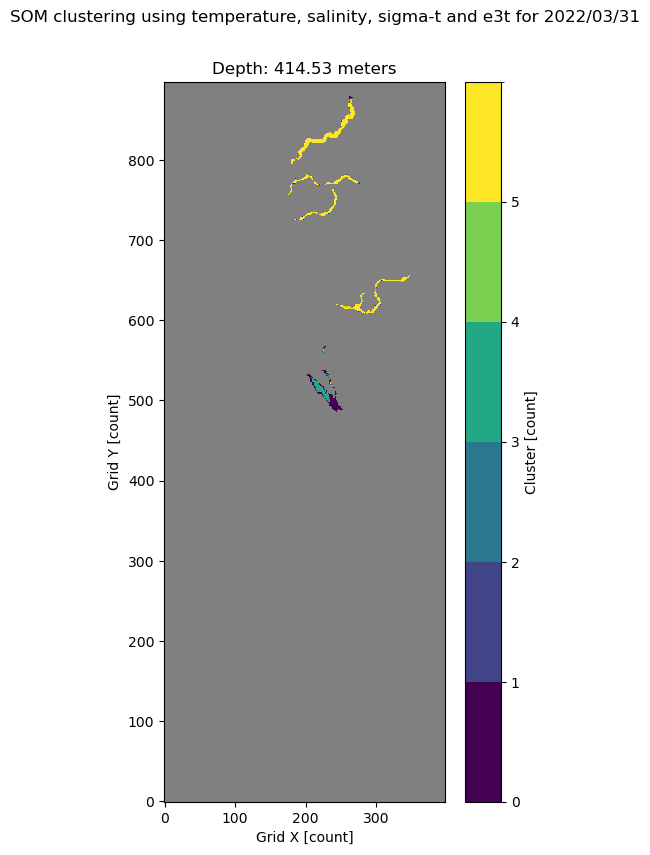

IndexError: index 0 is out of bounds for axis 0 with size 0

In [7]:
ds, temp, saline, sigma, cell, date, mask = datasets_preparation()

for depth in range (0, ds['deptht'].size+1):

    temp, saline, sigma, cell = masking(depth, temp, saline, sigma, cell, mask)
    unique, counts, inputs, predictions, clusters = som(depth, temp, saline, sigma, cell)
    printing(inputs, predictions, unique, counts)
    plotting (depth, clusters, unique)
